In [1]:
import polars as pl
from polars.exceptions import ColumnNotFoundError
import numpy as np
import ast
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['timezone'] = 'Europe/Moscow'

from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo
import pickle
from tqdm.notebook import tqdm
from itertools import product

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, root_mean_squared_error

from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name
db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

from bot.analysis.pair_trading import backtest
from bot.utils.pair_trading import make_df_from_orderbooks, make_trunc_df, create_zscore_df, select_cols_1tf
from bot.analysis.strategy_analysis import analyze_strategy
from bot.utils.files import load_config

#### Подготовка данных

In [2]:
config = load_config('./bot/config/config.yaml')

valid_time = config['valid_time']
end_time = config['end_time']
search_space = config['search_space']
pairs_file = config['token_pairs_file']

with open("./data/coin_information.pkl", "rb") as f:
    coin_information = pickle.load(f)

token_pairs = []
with open(pairs_file, 'r') as file:
    for line in file:
        a, b = line.strip().split()
        token_pairs.append((a, b))

In [3]:
leverage = 2

tf = '1h'
winds = np.array([48, 64, 72, 96, 120])
in_params = (2.75, 2.5, 2.25, 2.0, 1.8)
out_params = (0.0, 0.25, 0.5)
methods = ('dist', )

dist_in = 0
dist_out = 0

s_len = len(winds) * len(in_params) * len(out_params) * len(token_pairs) * len(methods)
all_lists = [winds, in_params, out_params]

print('Whole search space size:', s_len)

Whole search space size: 8625


In [4]:
metrics_arr = []

with tqdm(total=s_len, desc="Обработка", unit="iter") as progress_bar:
    for token_1, token_2 in token_pairs:
        dp_1 = float(coin_information['bybit_linear'][token_1 + '_USDT']['qty_step'])
        ps_1 = int(coin_information['bybit_linear'][token_1 + '_USDT']['price_scale'])
        dp_2 = float(coin_information['bybit_linear'][token_2 + '_USDT']['qty_step'])
        ps_2 = int(coin_information['bybit_linear'][token_2 + '_USDT']['price_scale'])

        for method in methods:
            filepath = f'./data/pair_backtest/{token_1}_{token_2}_1h_{method}.parquet'
            try:
                df = pl.read_parquet(filepath, low_memory=True, rechunk=True, use_pyarrow=True)
            except FileNotFoundError:
                print(f'FileNotFoundError!: {filepath}')
                continue
    
            end_date = df['time'][-1]
    
            for wind, in_, out_ in product(*all_lists):
                progress_bar.update(1)
                metrics = dict()

                cols = ['time', 'ts', token_1, f'{token_1}_size', f'{token_1}_bid_price', f'{token_1}_ask_price',
                        f'{token_1}_bid_size', f'{token_1}_ask_size', token_2, f'{token_2}_size',
                        f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
                        f'z_score_{wind}_{tf}']

                tdf = df.select(cols).rename({f'z_score_{wind}_{tf}': 'z_score'}).drop_nulls()

                trades_df = backtest(tdf, token_1, token_2, dp_1, dp_2, ps_1, ps_2,
                        thresh_low_in=-in_, thresh_low_out=-out_, thresh_high_in=in_, thresh_high_out=out_,
                        long_possible=True, short_possible=True,
                        balance=100, order_size=50, fee_rate=0.00055, stop_loss_std=8.0, sl_method='leave',
                        sl_seconds = 60, leverage=leverage, dist_in=0, dist_out=0,
                        verbose=0)

                if trades_df.height > 1:
                    metrics = analyze_strategy(trades_df, start_date=valid_time, end_date=end_date, initial_balance=100.0)

                if metrics:
                    metrics_arr.append({
                        'token_1': token_1, 'token_2': token_2, 'tf': tf, 'wind': wind, 'spr_method': method,
                        'thresh_in': in_, 'thresh_out': out_, 'dist_in': dist_in, 'dist_out': dist_out,
                        'n_trades': metrics['n_trades'], 'duration_avg': metrics['duration_avg'],
                        'stop_losses': metrics['stop_losses'], 'liquidations': metrics['liquidations'],
                        'profit': metrics['profit'], 'profit_ratio': metrics['profit_ratio'],
                        'max_profit': metrics['max_profit'], 'max_drawdown': metrics['max_drawdown'],
                        'max_loss': metrics['max_loss'], 'avg_profit': metrics['avg_profit'],
                        'profit_std': metrics['profit_std']})

mass_output = pl.DataFrame(metrics_arr).sort(by='profit', descending=True)

Обработка:   0%|          | 0/8625 [00:00<?, ?iter/s]

In [5]:
# Результаты для конкретных пар на общем тесте
res_df = mass_output.group_by('token_1', 'token_2').agg(
            pl.col('profit').mean().round(2).alias('avg_profit'),
            pl.col('profit').std().round(2).alias('profit_std'),
            pl.col('max_loss').min().round(2).alias('max_loss'),
            pl.col('max_drawdown').mean().round(2).alias('avg_drawdown'),
            pl.col('max_drawdown').min().round(2).alias('max_drawdown'),
            pl.col('duration_avg').mean().alias('avg_duration'),
            pl.col('profit_ratio').mean().round(2).alias('avg_pr_ratio'),
            pl.col('n_trades').mean().cast(pl.Int64).alias('avg_trades'),
        ).sort('avg_pr_ratio', descending=True)
res_df

shape: (110, 10)
┌─────────┬─────────┬─────────┬─────────┬───┬─────────┬─────────┬─────────┬─────────┐
│ token_1 ┆ token_2 ┆ avg_pro ┆ profit_ ┆ … ┆ max_dra ┆ avg_dur ┆ avg_pr_ ┆ avg_tra │
│ ---     ┆ ---     ┆ fit     ┆ std     ┆   ┆ wdown   ┆ ation   ┆ ratio   ┆ des     │
│ str     ┆ str     ┆ ---     ┆ ---     ┆   ┆ ---     ┆ ---     ┆ ---     ┆ ---     │
│         ┆         ┆ f64     ┆ f64     ┆   ┆ f64     ┆ duratio ┆ f64     ┆ i64     │
│         ┆         ┆         ┆         ┆   ┆         ┆ n[μs]   ┆         ┆         │
╞═════════╪═════════╪═════════╪═════════╪═══╪═════════╪═════════╪═════════╪═════════╡
│ GLM     ┆ MANTA   ┆ 17.79   ┆ 6.62    ┆ … ┆ -0.57   ┆ 1d 5h   ┆ 3.3     ┆ 2       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 57m 3s  ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 800ms   ┆         ┆         │
│ FARTCOI ┆ RUNE    ┆ 15.17   ┆ 10.92   ┆ … ┆ -8.86   ┆ 1d 3h   ┆ 2.31    ┆ 2       │
│ N       ┆         ┆         ┆         ┆   ┆         ┆ 37m 9s  ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 300ms   ┆         ┆         │
│ PNUT    ┆ SAND    ┆ 10.43   ┆ 2.75    ┆ … ┆ -0.27   ┆ 8h 16m  ┆ 2.05    ┆ 4       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 33s     ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 720ms   ┆         ┆         │
│ JASMY   ┆ VET     ┆ 8.75    ┆ 2.35    ┆ … ┆ -1.05   ┆ 23h 31m ┆ 1.73    ┆ 2       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 25s 893 ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 333µs   ┆         ┆         │
│ GMT     ┆ KAS     ┆ 8.45    ┆ 2.34    ┆ … ┆ 0.0     ┆ 10h 15m ┆ 1.67    ┆ 3       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 13s     ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 41666µs ┆         ┆         │
│ …       ┆ …       ┆ …       ┆ …       ┆ … ┆ …       ┆ …       ┆ …       ┆ …       │
│ MANA    ┆ POL     ┆ -3.6    ┆ 1.09    ┆ … ┆ -5.79   ┆ 1d 14h  ┆ -0.46   ┆ 2       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 24m 25s ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 500ms   ┆         ┆         │
│ ARKM    ┆ MANTA   ┆ -5.83   ┆ 3.18    ┆ … ┆ -13.98  ┆ 1d 10h  ┆ -0.47   ┆ 2       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 42m 31s ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 541666µ ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ s       ┆         ┆         │
│ ATOM    ┆ TON     ┆ -4.2    ┆ 0.73    ┆ … ┆ -6.08   ┆ 1d 9h   ┆ -0.49   ┆ 2       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 51m 29s ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 666666µ ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ s       ┆         ┆         │
│ FLOW    ┆ MANA    ┆ -4.71   ┆ 0.15    ┆ … ┆ -6.11   ┆ 1d 9h   ┆ -0.54   ┆ 2       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 19m 10s ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 666666µ ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ s       ┆         ┆         │
│ DRIFT   ┆ ETHFI   ┆ -4.75   ┆ 3.92    ┆ … ┆ -9.53   ┆ 2d 38m  ┆ -0.54   ┆ 2       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 58s     ┆         ┆         │
└─────────┴─────────┴─────────┴─────────┴───┴─────────┴─────────┴─────────┴─────────┘

In [9]:
# Текущие пары, показавшие отрицательный результат на бектесте
current_pairs = []
with open('./bot/config/token_pairs.txt', 'r') as file:
    for line in file:
        a, b = line.strip().split()
        current_pairs.append((a, b))

for row in res_df.iter_rows(named=True):
    t1 = row['token_1']
    t2 = row['token_2']

    if (t1, t2) in current_pairs and row['avg_profit'] < 0:
        print(t1, t2, row['avg_profit'])


In [10]:
# Выкидываем все пары, показашие плохой результат, и сохраняем хорошие пары в файл
res_df = res_df.filter(
    (pl.col('avg_profit') > 4.0) & (pl.col('avg_pr_ratio') > 0.5)
)
res_df.sort(by='avg_pr_ratio', descending=True)

shape: (50, 10)
┌─────────┬─────────┬─────────┬─────────┬───┬─────────┬─────────┬─────────┬─────────┐
│ token_1 ┆ token_2 ┆ avg_pro ┆ profit_ ┆ … ┆ max_dra ┆ avg_dur ┆ avg_pr_ ┆ avg_tra │
│ ---     ┆ ---     ┆ fit     ┆ std     ┆   ┆ wdown   ┆ ation   ┆ ratio   ┆ des     │
│ str     ┆ str     ┆ ---     ┆ ---     ┆   ┆ ---     ┆ ---     ┆ ---     ┆ ---     │
│         ┆         ┆ f64     ┆ f64     ┆   ┆ f64     ┆ duratio ┆ f64     ┆ i64     │
│         ┆         ┆         ┆         ┆   ┆         ┆ n[μs]   ┆         ┆         │
╞═════════╪═════════╪═════════╪═════════╪═══╪═════════╪═════════╪═════════╪═════════╡
│ GLM     ┆ MANTA   ┆ 17.79   ┆ 6.62    ┆ … ┆ -0.57   ┆ 1d 5h   ┆ 3.3     ┆ 2       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 57m 3s  ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 800ms   ┆         ┆         │
│ FARTCOI ┆ RUNE    ┆ 15.17   ┆ 10.92   ┆ … ┆ -8.86   ┆ 1d 3h   ┆ 2.31    ┆ 2       │
│ N       ┆         ┆         ┆         ┆   ┆         ┆ 37m 9s  ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 300ms   ┆         ┆         │
│ PNUT    ┆ SAND    ┆ 10.43   ┆ 2.75    ┆ … ┆ -0.27   ┆ 8h 16m  ┆ 2.05    ┆ 4       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 33s     ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 720ms   ┆         ┆         │
│ JASMY   ┆ VET     ┆ 8.75    ┆ 2.35    ┆ … ┆ -1.05   ┆ 23h 31m ┆ 1.73    ┆ 2       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 25s 893 ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 333µs   ┆         ┆         │
│ GMT     ┆ KAS     ┆ 8.45    ┆ 2.34    ┆ … ┆ 0.0     ┆ 10h 15m ┆ 1.67    ┆ 3       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 13s     ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 41666µs ┆         ┆         │
│ …       ┆ …       ┆ …       ┆ …       ┆ … ┆ …       ┆ …       ┆ …       ┆ …       │
│ MANTA   ┆ SUSHI   ┆ 5.88    ┆ 0.42    ┆ … ┆ -2.12   ┆ 1d 12h  ┆ 0.85    ┆ 2       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 52m 9s  ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 500ms   ┆         ┆         │
│ STX     ┆ WIF     ┆ 4.57    ┆ 2.75    ┆ … ┆ -5.76   ┆ 12h 7m  ┆ 0.83    ┆ 3       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 5s      ┆         ┆         │
│ APT     ┆ INJ     ┆ 4.18    ┆ 1.69    ┆ … ┆ -2.01   ┆ 22h 31m ┆ 0.82    ┆ 2       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 20s 766 ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 666µs   ┆         ┆         │
│ ARKM    ┆ STX     ┆ 4.12    ┆ 1.19    ┆ … ┆ 0.0     ┆ 17h 47m ┆ 0.81    ┆ 2       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 33s 306 ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 666µs   ┆         ┆         │
│ JUP     ┆ STX     ┆ 4.02    ┆ 1.19    ┆ … ┆ -0.24   ┆ 20h 54m ┆ 0.79    ┆ 2       │
│         ┆         ┆         ┆         ┆   ┆         ┆ 29s     ┆         ┆         │
│         ┆         ┆         ┆         ┆   ┆         ┆ 500ms   ┆         ┆         │
└─────────┴─────────┴─────────┴─────────┴───┴─────────┴─────────┴─────────┴─────────┘

In [13]:
# Теперь для плюсовых пар ещё раз прогоним общий бектест для подбора наилучших параметров только на этих парах.
token_pairs = []
for row in res_df.iter_rows(named=True):
    token_pairs.append([row['token_1'], row['token_2']])
len(token_pairs)

50

In [16]:
current_pairs = []
with open('./bot/config/token_pairs.txt', 'r') as file:
    for line in file:
        a, b = line.strip().split()
        current_pairs.append((a, b))

============= GLM - MANTA =============
ACTIVE!
wind: 64; profit:  22.1; ratio:  4.09; drawdown: 0.0; n_trades: 2
wind: 72; profit:  19.0; ratio:  3.46; drawdown: 0.0; n_trades: 2
wind: 96; profit:  16.8; ratio:  3.17; drawdown: 0.0; n_trades: 2


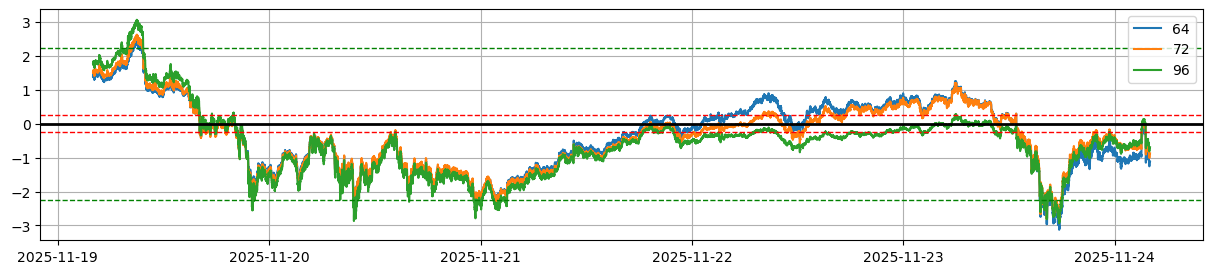

============= FARTCOIN - RUNE =============
wind: 64; profit:  21.5; ratio:  3.09; drawdown: -0.54; n_trades: 2
wind: 72; profit:  26.4; ratio:  4.10; drawdown: 0.0; n_trades: 2
wind: 96; profit:  22.9; ratio:  3.58; drawdown: 0.0; n_trades: 2


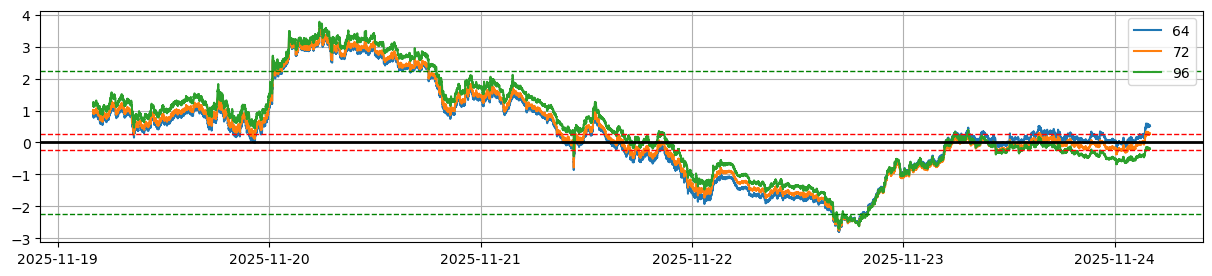

============= PNUT - SAND =============
ACTIVE!
wind: 64; profit:  12.5; ratio:  2.46; drawdown: 0.0; n_trades: 5
wind: 72; profit:  12.7; ratio:  2.49; drawdown: 0.0; n_trades: 5
wind: 96; profit:  13.9; ratio:  2.72; drawdown: 0.0; n_trades: 5


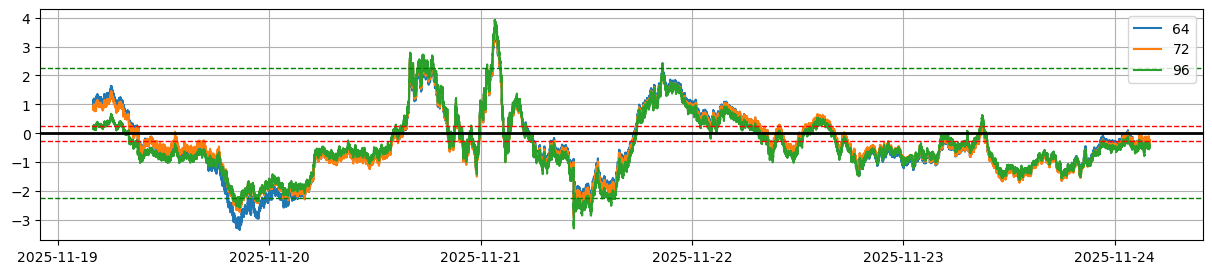

============= JASMY - VET =============
wind: 64; profit:  11.6; ratio:  2.30; drawdown: 0.0; n_trades: 3
wind: 72; profit:  12.1; ratio:  2.40; drawdown: 0.0; n_trades: 3
wind: 96; profit:   7.3; ratio:  1.45; drawdown: 0.0; n_trades: 2


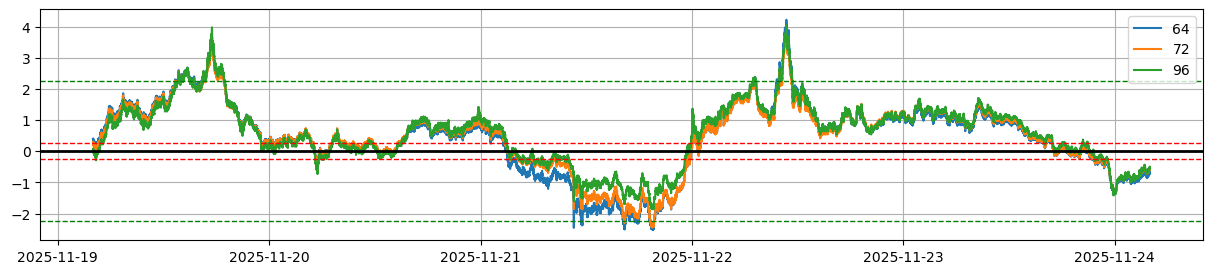

============= GMT - KAS =============
wind: 64; profit:   8.9; ratio:  1.74; drawdown: 0.0; n_trades: 3
wind: 72; profit:   5.2; ratio:  1.03; drawdown: 0.0; n_trades: 2
wind: 96; profit:   5.9; ratio:  1.19; drawdown: 0.0; n_trades: 2


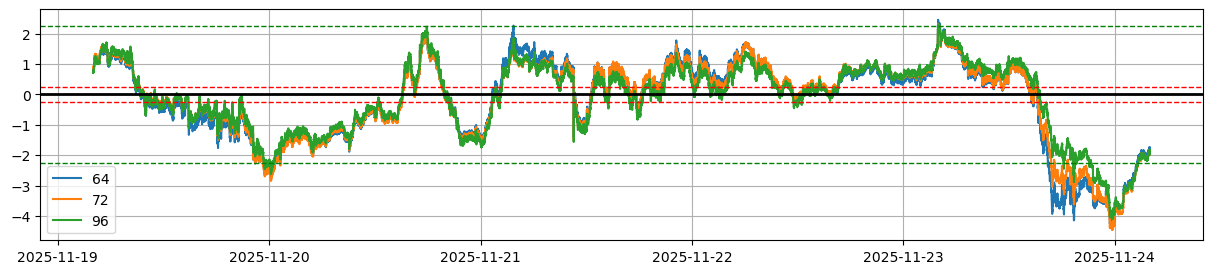

============= GALA - JASMY =============
wind: 64; profit:  10.1; ratio:  1.90; drawdown: 0.0; n_trades: 2
wind: 72; profit:  11.2; ratio:  2.14; drawdown: 0.0; n_trades: 2
wind: 96; profit:  11.1; ratio:  2.13; drawdown: 0.0; n_trades: 2


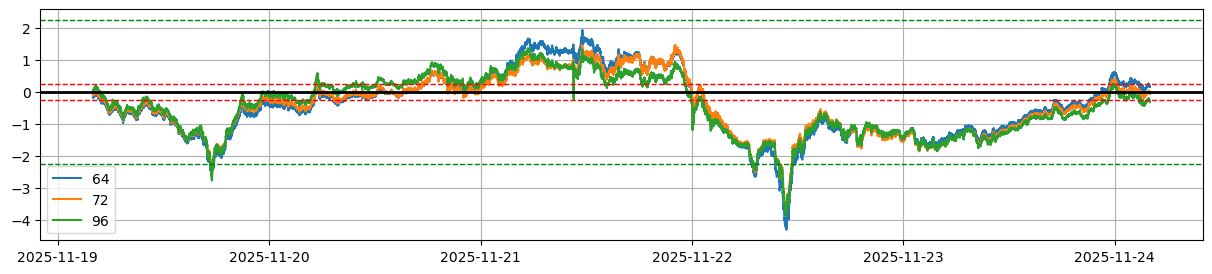

============= INJ - TON =============
ACTIVE!
wind: 64; profit:   4.5; ratio:  0.88; drawdown: 0.0; n_trades: 2
wind: 72; profit:   6.2; ratio:  1.22; drawdown: 0.0; n_trades: 2
wind: 96; profit:  14.9; ratio:  2.89; drawdown: 0.0; n_trades: 3


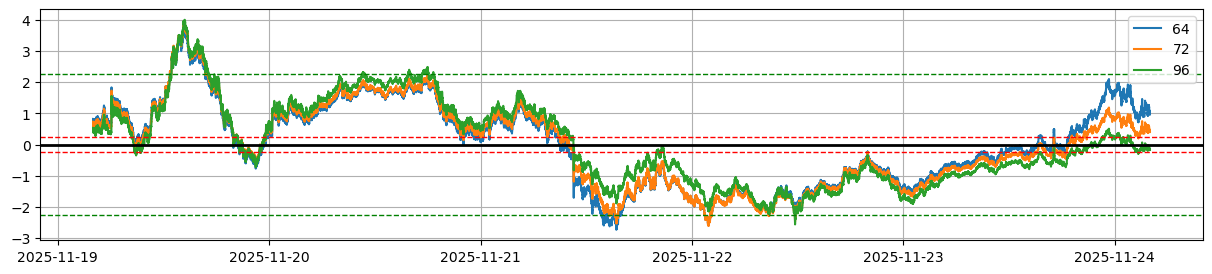

============= ARKM - JUP =============
ACTIVE!
wind: 64; profit:   9.6; ratio:  1.89; drawdown: 0.0; n_trades: 4
wind: 72; profit:   7.4; ratio:  1.47; drawdown: 0.0; n_trades: 3
wind: 96; profit:   9.0; ratio:  1.79; drawdown: 0.0; n_trades: 4


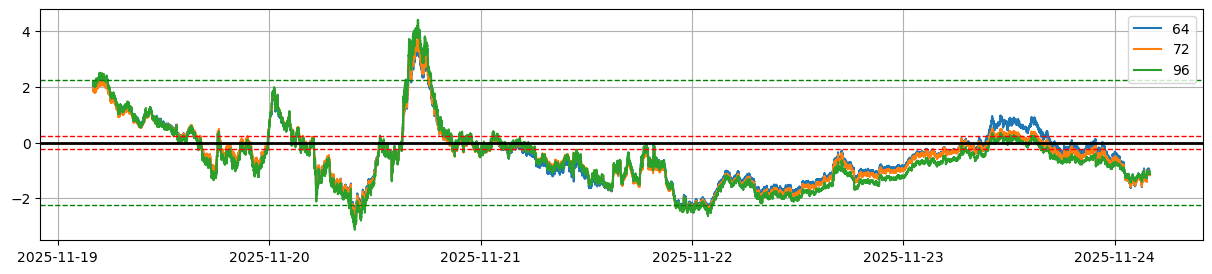

============= JUP - PNUT =============
wind: 64; profit:  10.7; ratio:  2.12; drawdown: 0.0; n_trades: 4
wind: 72; profit:   6.0; ratio:  1.18; drawdown: 0.0; n_trades: 3
wind: 96; profit:   4.8; ratio:  0.95; drawdown: 0.0; n_trades: 2


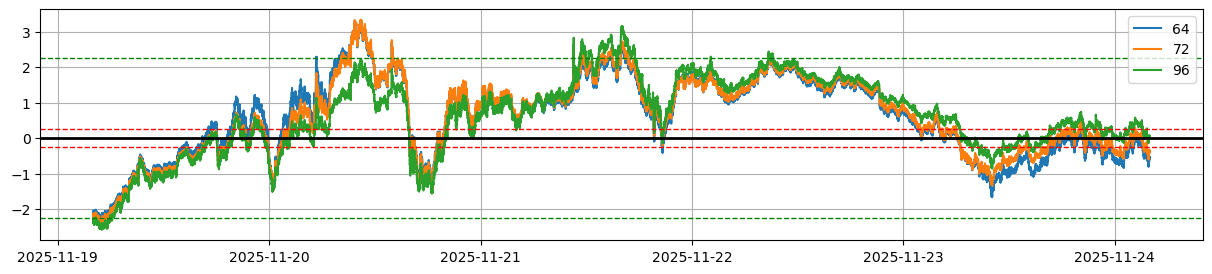

============= FARTCOIN - WIF =============
wind: 64; profit:   5.9; ratio:  0.78; drawdown: -2.95; n_trades: 2
wind: 72; profit:  10.9; ratio:  1.48; drawdown: -2.11; n_trades: 2
wind: 96; profit:  18.0; ratio:  2.88; drawdown: 0.0; n_trades: 2


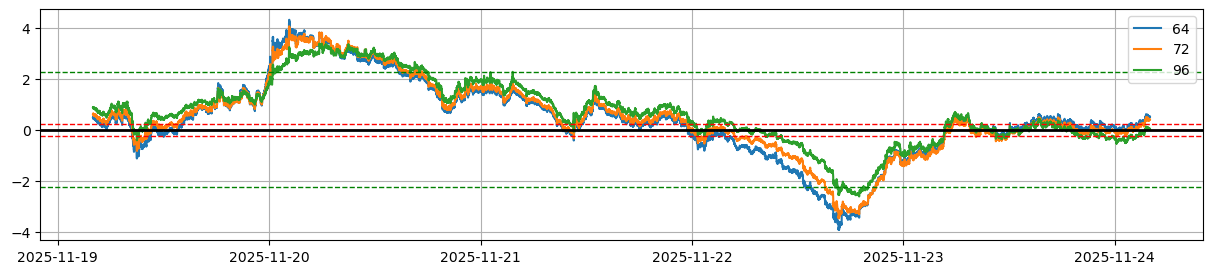

============= ENA - LDO =============
wind: 64; profit:   8.4; ratio:  1.66; drawdown: 0.0; n_trades: 4
wind: 72; profit:   8.8; ratio:  1.74; drawdown: 0.0; n_trades: 4
wind: 96; profit:   4.1; ratio:  0.81; drawdown: 0.0; n_trades: 2


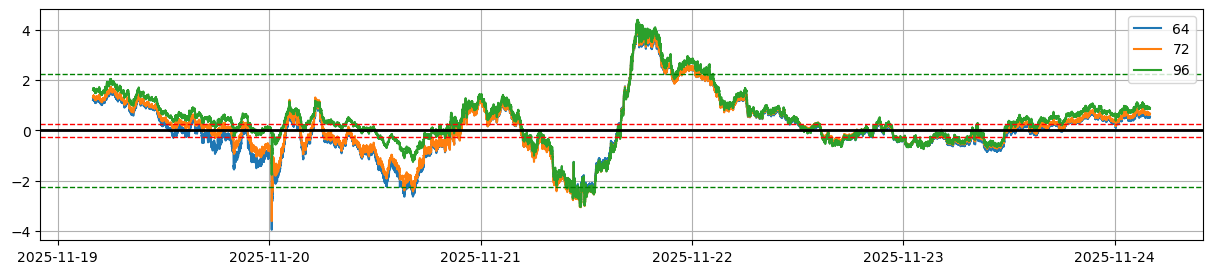

============= JUP - SAND =============
ACTIVE!
wind: 64; profit:   4.3; ratio:  0.84; drawdown: 0.0; n_trades: 3
wind: 72; profit:   8.1; ratio:  1.60; drawdown: 0.0; n_trades: 4
wind: 96; profit:   6.4; ratio:  1.27; drawdown: 0.0; n_trades: 3


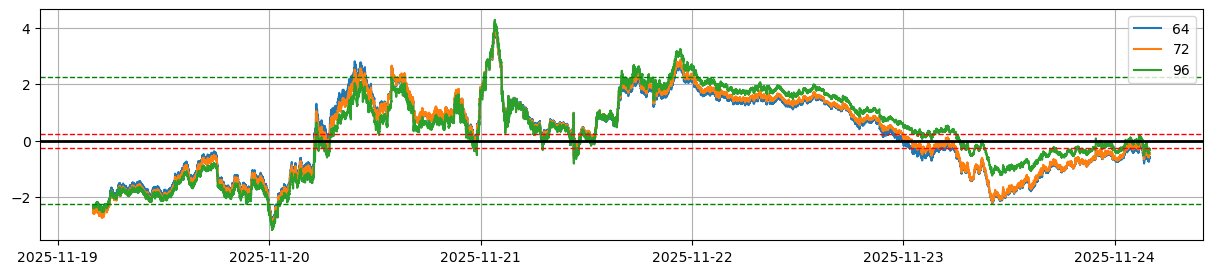

============= DYDX - ONDO =============
ACTIVE!
wind: 64; profit:   7.9; ratio:  1.55; drawdown: 0.0; n_trades: 4
wind: 72; profit:   8.5; ratio:  1.67; drawdown: 0.0; n_trades: 4
wind: 96; profit:   4.9; ratio:  0.95; drawdown: 0.0; n_trades: 2


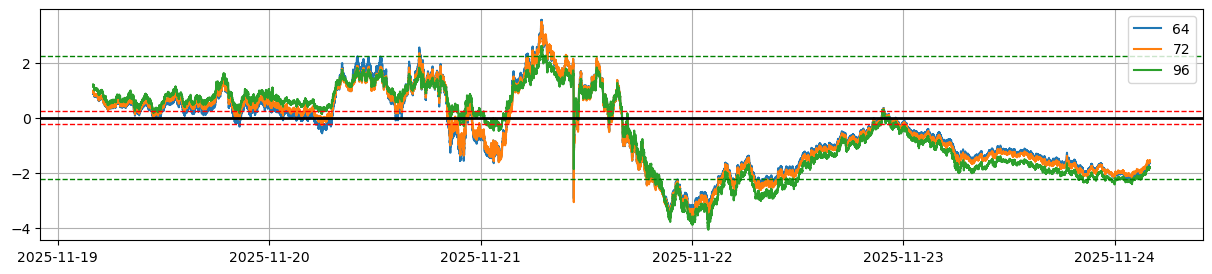

============= SUI - TON =============
ACTIVE!
wind: 64; profit:   6.4; ratio:  1.26; drawdown: 0.0; n_trades: 3
wind: 72; profit:   8.0; ratio:  1.58; drawdown: 0.0; n_trades: 4
wind: 96; profit:   9.2; ratio:  1.82; drawdown: 0.0; n_trades: 4


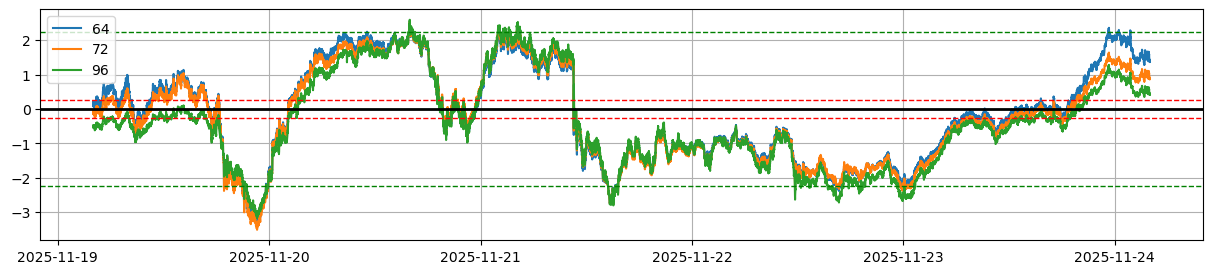

============= ARKM - SAND =============
wind: 64; profit:   7.2; ratio:  1.40; drawdown: 0.0; n_trades: 3
wind: 72; profit:   7.1; ratio:  1.38; drawdown: 0.0; n_trades: 3
wind: 96; profit:   7.8; ratio:  1.54; drawdown: 0.0; n_trades: 3


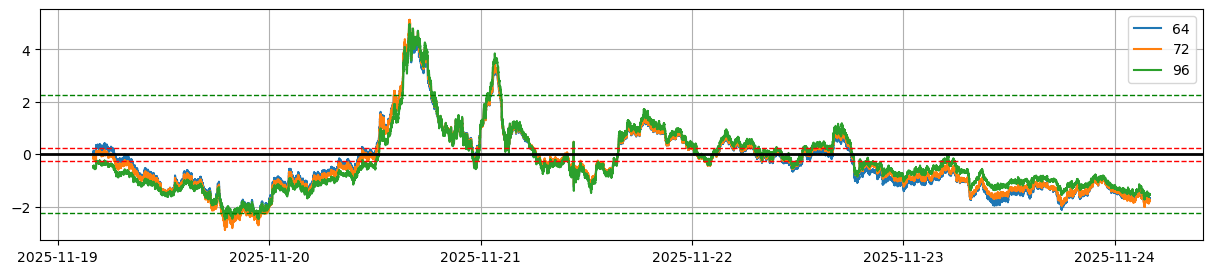

============= PNUT - THETA =============
ACTIVE!
wind: 64; profit:   6.7; ratio:  1.31; drawdown: 0.0; n_trades: 4
wind: 72; profit:   7.2; ratio:  1.42; drawdown: 0.0; n_trades: 4
wind: 96; profit:   7.5; ratio:  1.50; drawdown: 0.0; n_trades: 4


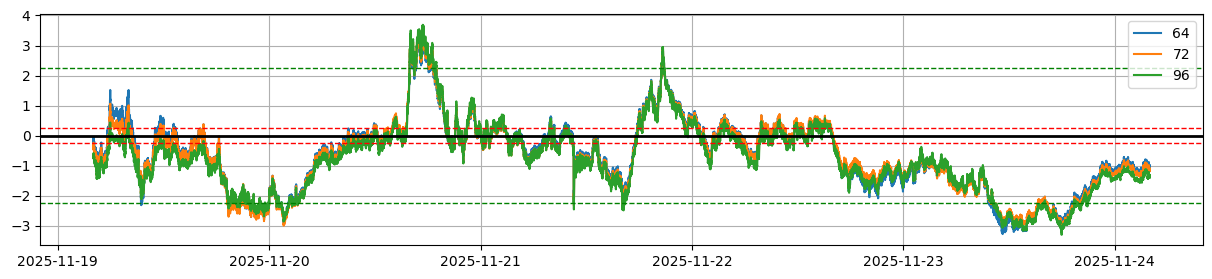

============= INJ - SUI =============
wind: 64; profit:   3.5; ratio:  0.68; drawdown: 0.0; n_trades: 2
wind: 72; profit:   4.0; ratio:  0.77; drawdown: 0.0; n_trades: 2
wind: 96; profit:   1.5; ratio:  0.29; drawdown: 0.0; n_trades: 1


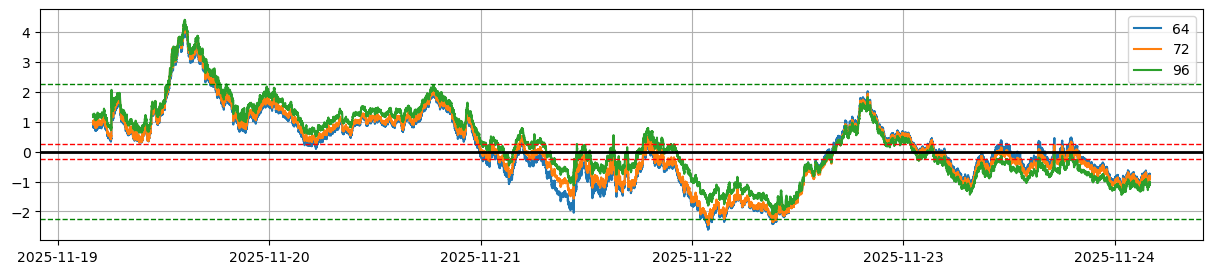

============= ARB - LDO =============
wind: 64; profit:   6.8; ratio:  1.30; drawdown: 0.0; n_trades: 3
wind: 72; profit:   7.6; ratio:  1.47; drawdown: 0.0; n_trades: 3
wind: 96; profit:   8.9; ratio:  1.75; drawdown: 0.0; n_trades: 3


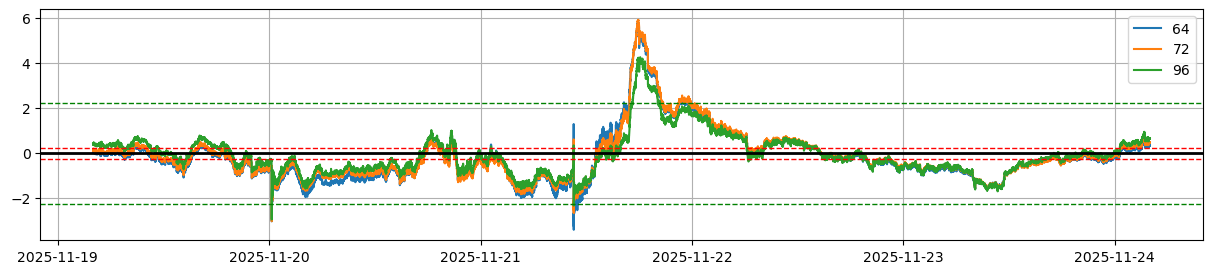

============= PNUT - STX =============
wind: 64; profit:   7.7; ratio:  1.45; drawdown: 0.0; n_trades: 2
wind: 72; profit:  11.0; ratio:  2.10; drawdown: 0.0; n_trades: 3
wind: 96; profit:   4.5; ratio:  0.88; drawdown: 0.0; n_trades: 2


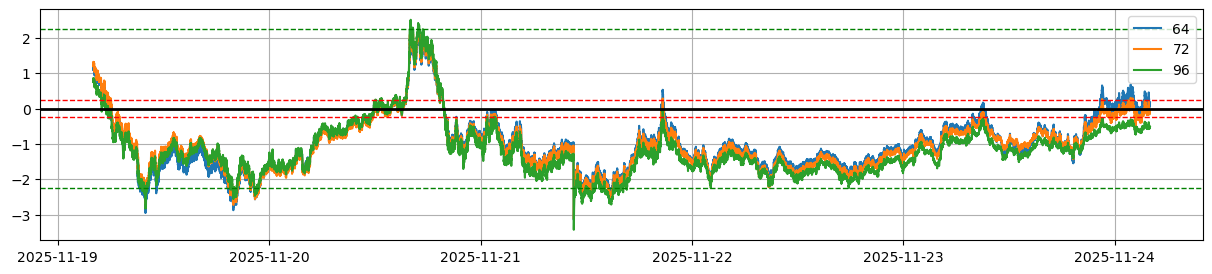

============= CELO - PNUT =============
wind: 64; profit:   7.5; ratio:  1.48; drawdown: 0.0; n_trades: 3
wind: 72; profit:   9.8; ratio:  1.91; drawdown: 0.0; n_trades: 3


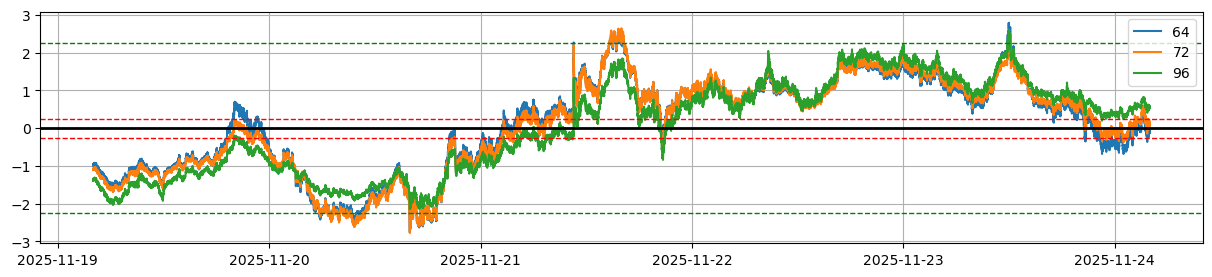

============= S - THETA =============
wind: 64; profit:   6.5; ratio:  1.30; drawdown: 0.0; n_trades: 5
wind: 72; profit:   6.4; ratio:  1.28; drawdown: 0.0; n_trades: 5
wind: 96; profit:   5.9; ratio:  1.17; drawdown: 0.0; n_trades: 4


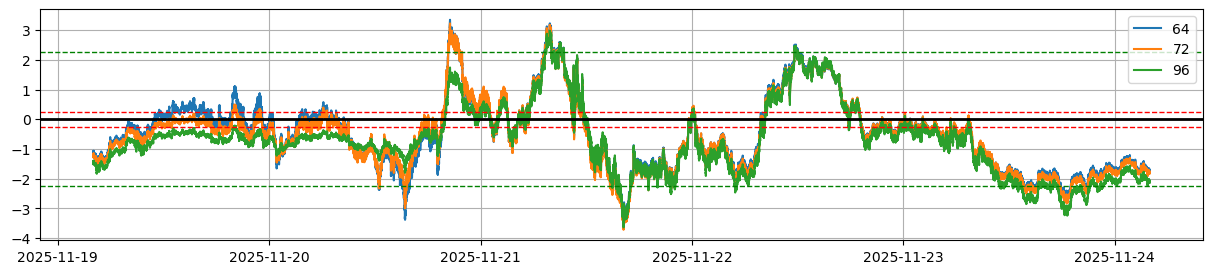

============= PNUT - S =============
wind: 64; profit:   6.1; ratio:  1.21; drawdown: 0.0; n_trades: 3
wind: 72; profit:   4.4; ratio:  0.88; drawdown: 0.0; n_trades: 2
wind: 96; profit:   6.9; ratio:  1.36; drawdown: 0.0; n_trades: 3


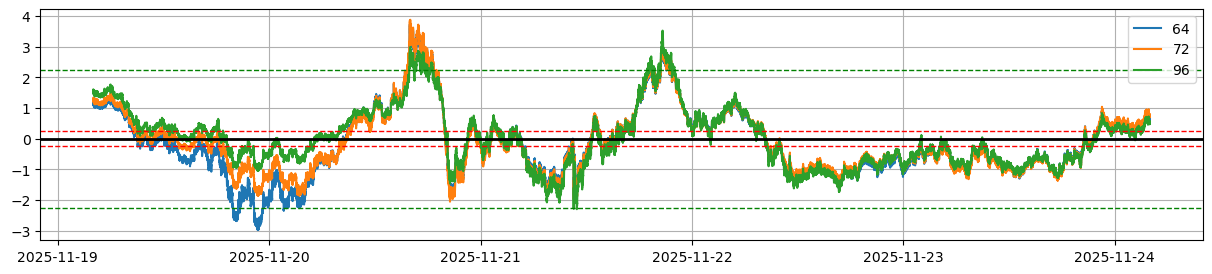

============= GRT - KAS =============
ACTIVE!
wind: 64; profit:   7.4; ratio:  1.48; drawdown: 0.0; n_trades: 3
wind: 72; profit:   2.2; ratio:  0.43; drawdown: 0.0; n_trades: 1
wind: 96; profit:   5.2; ratio:  1.04; drawdown: 0.0; n_trades: 2


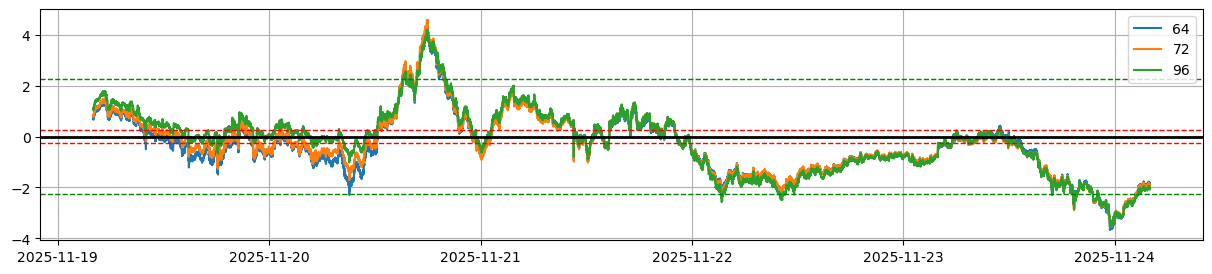

============= JUP - POL =============
wind: 64; profit:   6.2; ratio:  1.24; drawdown: 0.0; n_trades: 3
wind: 72; profit:   7.0; ratio:  1.39; drawdown: 0.0; n_trades: 3
wind: 96; profit:   4.6; ratio:  0.91; drawdown: 0.0; n_trades: 2


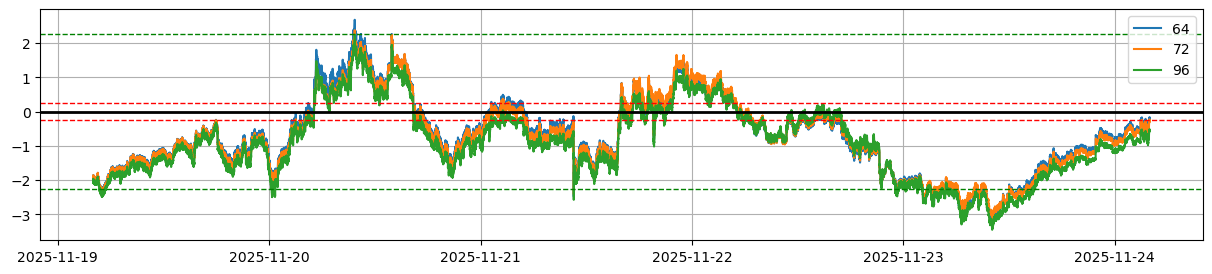

============= THETA - TON =============
wind: 64; profit:   8.1; ratio:  1.57; drawdown: 0.0; n_trades: 3
wind: 72; profit:   8.2; ratio:  1.57; drawdown: 0.0; n_trades: 3
wind: 96; profit:   6.4; ratio:  1.20; drawdown: 0.0; n_trades: 2


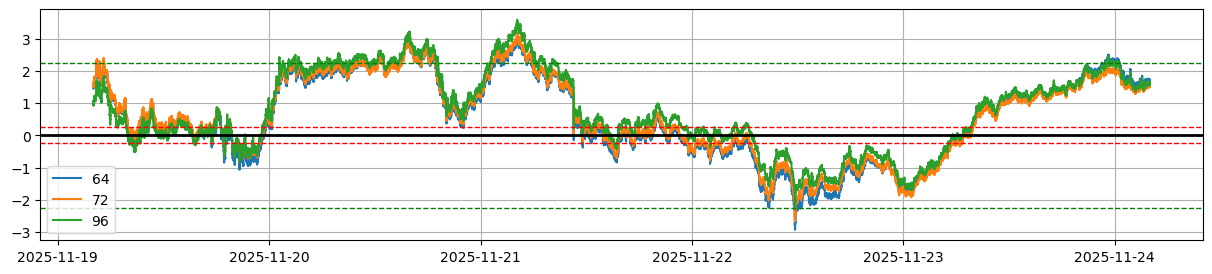

============= SAND - S =============
wind: 64; profit:   4.7; ratio:  0.93; drawdown: 0.0; n_trades: 4
wind: 72; profit:   6.7; ratio:  1.32; drawdown: 0.0; n_trades: 5
wind: 96; profit:   8.5; ratio:  1.69; drawdown: 0.0; n_trades: 5


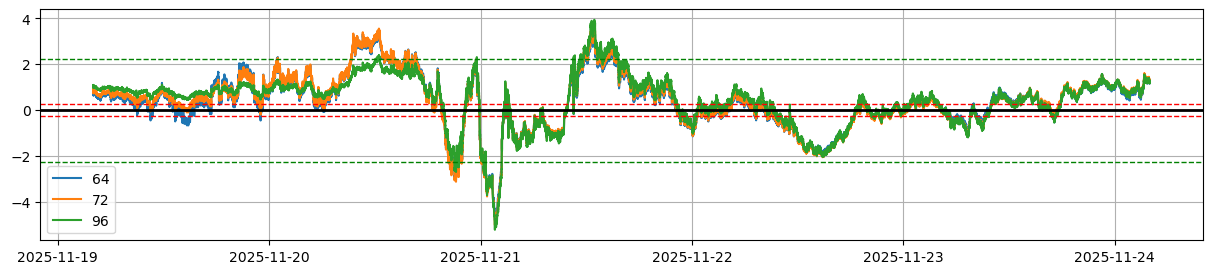

============= ETHFI - IMX =============
ACTIVE!
wind: 64; profit:   5.1; ratio:  1.02; drawdown: 0.0; n_trades: 1
wind: 72; profit:   5.4; ratio:  1.08; drawdown: 0.0; n_trades: 1
wind: 96; profit:  10.5; ratio:  2.08; drawdown: 0.0; n_trades: 2


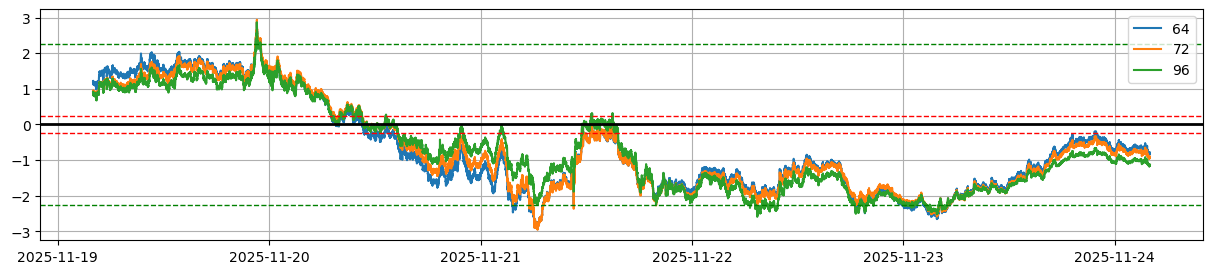

============= ARKM - DYDX =============
wind: 64; profit:   4.2; ratio:  0.85; drawdown: 0.0; n_trades: 2
wind: 72; profit:   4.9; ratio:  0.97; drawdown: 0.0; n_trades: 2
wind: 96; profit:   5.5; ratio:  1.08; drawdown: 0.0; n_trades: 2


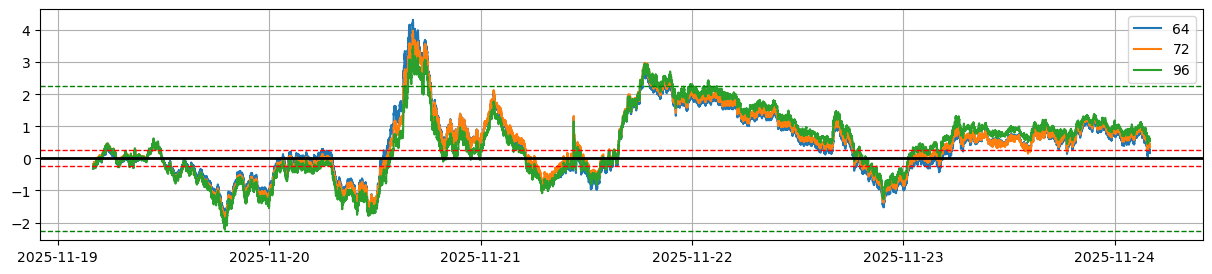

============= RUNE - WIF =============
wind: 64; profit:   6.7; ratio:  1.24; drawdown: -0.32; n_trades: 3
wind: 72; profit:   3.2; ratio:  0.62; drawdown: 0.0; n_trades: 2
wind: 96; profit:   5.5; ratio:  1.09; drawdown: 0.0; n_trades: 1


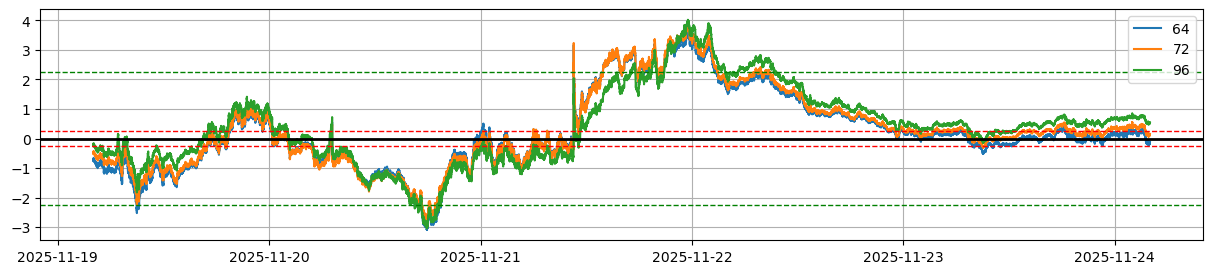

============= ONDO - THETA =============
wind: 64; profit:   5.6; ratio:  1.11; drawdown: 0.0; n_trades: 5
wind: 72; profit:   4.9; ratio:  0.96; drawdown: 0.0; n_trades: 4
wind: 96; profit:   5.4; ratio:  1.06; drawdown: 0.0; n_trades: 3


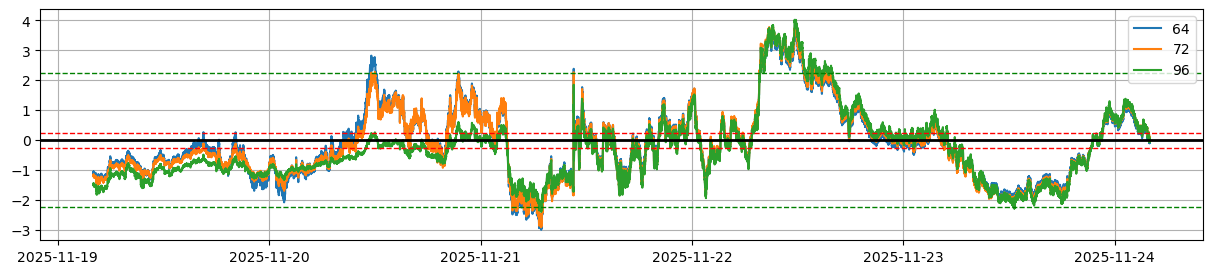

============= ARKM - PNUT =============
ACTIVE!
wind: 64; profit:   6.1; ratio:  1.22; drawdown: 0.0; n_trades: 4
wind: 72; profit:   2.9; ratio:  0.58; drawdown: 0.0; n_trades: 2
wind: 96; profit:   7.2; ratio:  1.42; drawdown: 0.0; n_trades: 3


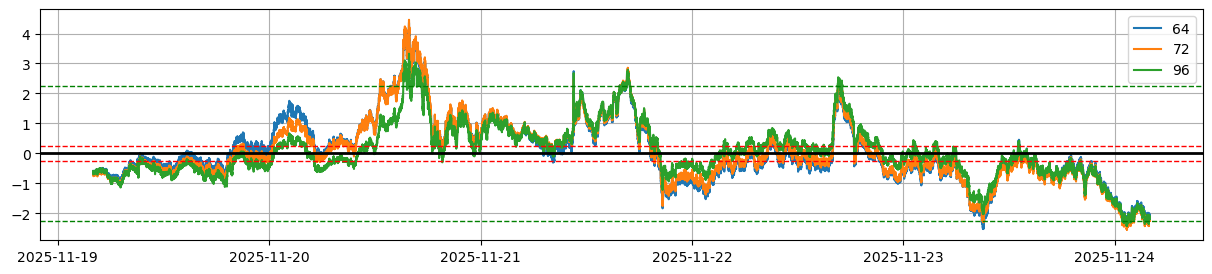

============= ADA - ARB =============
wind: 64; profit:   6.2; ratio:  1.23; drawdown: 0.0; n_trades: 3
wind: 72; profit:   6.7; ratio:  1.32; drawdown: 0.0; n_trades: 3
wind: 96; profit:   6.6; ratio:  1.31; drawdown: 0.0; n_trades: 3


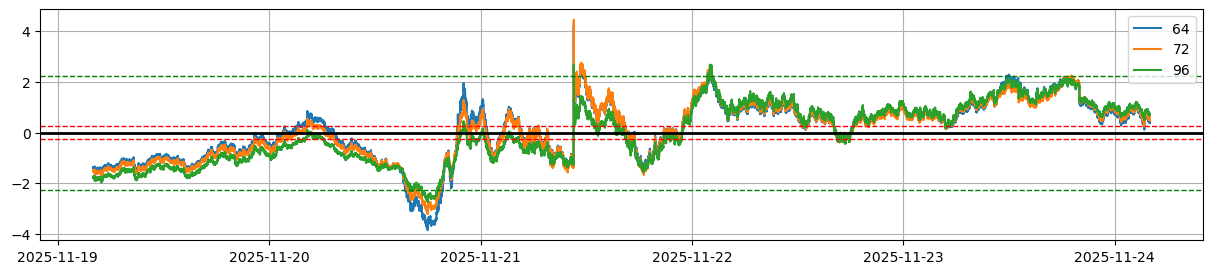

============= DOT - INJ =============
wind: 64; profit:   3.0; ratio:  0.60; drawdown: 0.0; n_trades: 2
wind: 72; profit:   3.8; ratio:  0.76; drawdown: 0.0; n_trades: 2
wind: 96; profit:   5.7; ratio:  1.12; drawdown: 0.0; n_trades: 2


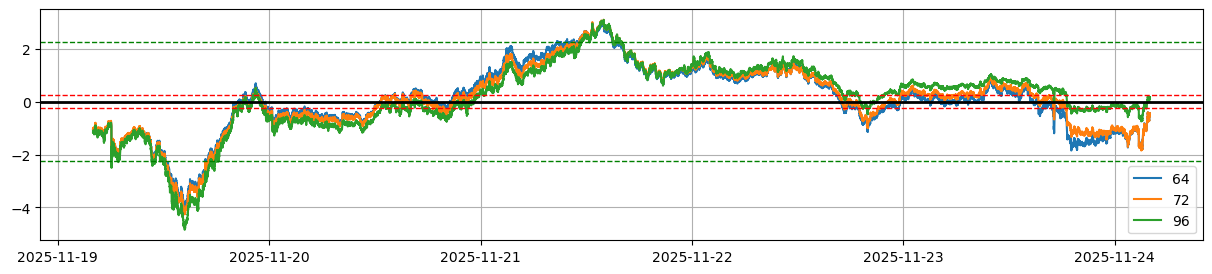

============= CELO - MANA =============
wind: 64; profit:   5.9; ratio:  1.16; drawdown: 0.0; n_trades: 3
wind: 72; profit:   4.2; ratio:  0.83; drawdown: 0.0; n_trades: 2
wind: 96; profit:   2.1; ratio:  0.42; drawdown: 0.0; n_trades: 1


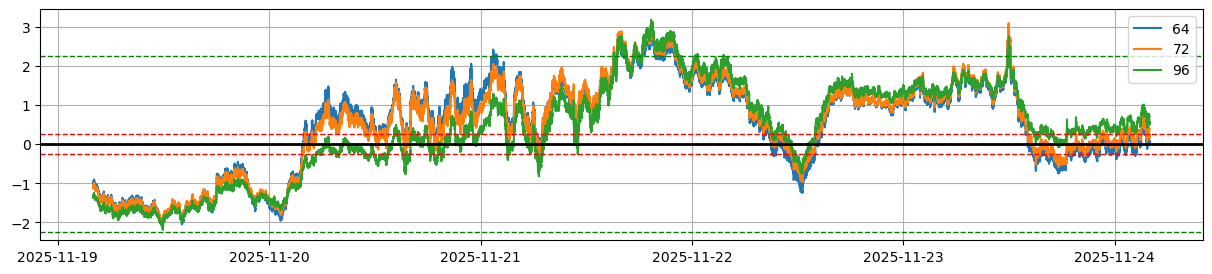

============= MOVE - PNUT =============
wind: 64; profit:   8.1; ratio:  1.60; drawdown: 0.0; n_trades: 3
wind: 72; profit:   6.4; ratio:  1.26; drawdown: 0.0; n_trades: 2
wind: 96; profit:   3.8; ratio:  0.76; drawdown: 0.0; n_trades: 1


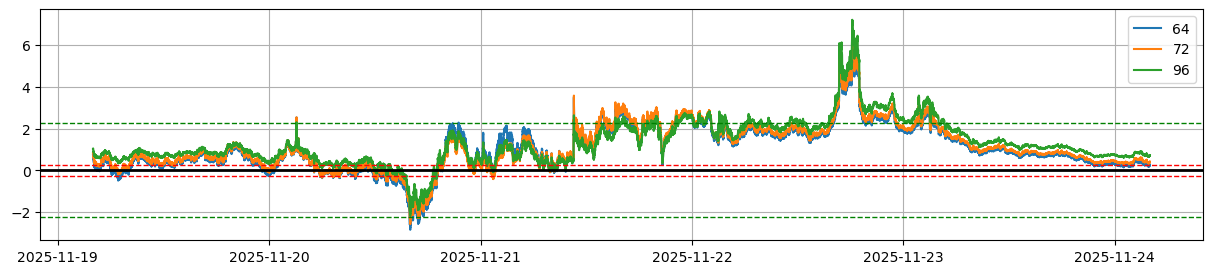

============= DRIFT - IMX =============
wind: 64; profit:   3.7; ratio:  0.68; drawdown: -0.33; n_trades: 2
wind: 72; profit:   7.0; ratio:  1.35; drawdown: 0.0; n_trades: 2
wind: 96; profit:   4.3; ratio:  0.86; drawdown: 0.0; n_trades: 1


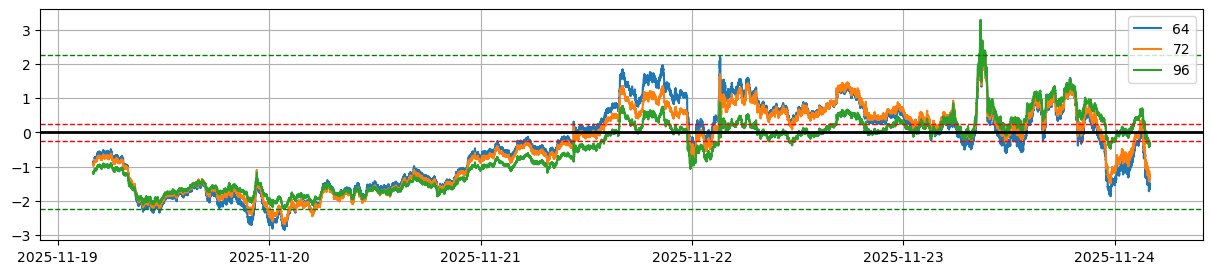

============= DYDX - JUP =============
wind: 64; profit:   8.9; ratio:  1.62; drawdown: -0.69; n_trades: 5
wind: 72; profit:   5.6; ratio:  1.09; drawdown: 0.0; n_trades: 2
wind: 96; profit:   3.8; ratio:  0.75; drawdown: 0.0; n_trades: 1


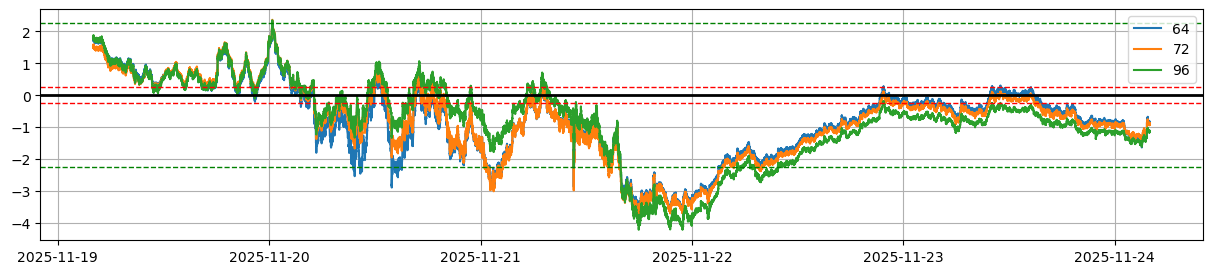

============= ALGO - ARB =============
wind: 64; profit:   1.1; ratio:  0.21; drawdown: 0.0; n_trades: 1
wind: 72; profit:   1.4; ratio:  0.27; drawdown: 0.0; n_trades: 1
wind: 96; profit:   1.5; ratio:  0.30; drawdown: 0.0; n_trades: 1


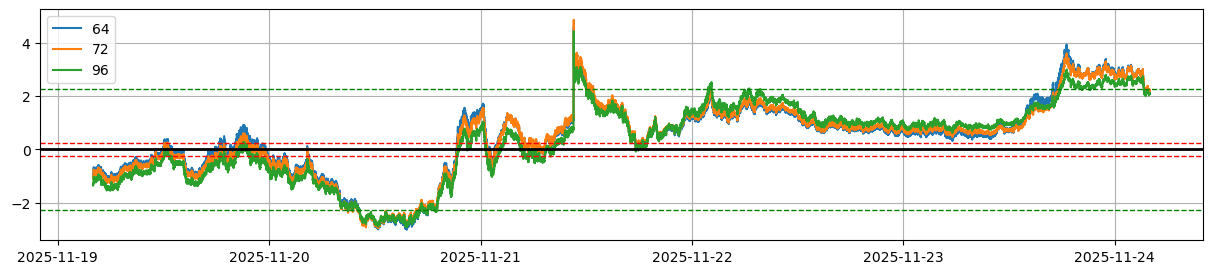

============= THETA - WIF =============
wind: 64; profit:   5.1; ratio:  1.02; drawdown: 0.0; n_trades: 2
wind: 72; profit:   3.5; ratio:  0.69; drawdown: 0.0; n_trades: 1
wind: 96; profit:   6.0; ratio:  1.20; drawdown: 0.0; n_trades: 2


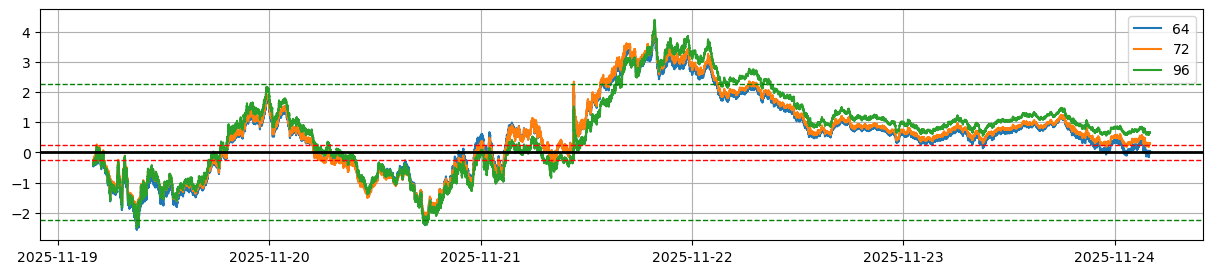

============= CRV - SUSHI =============
wind: 64; profit:   1.2; ratio:  0.24; drawdown: 0.0; n_trades: 1
wind: 72; profit:   4.7; ratio:  0.94; drawdown: 0.0; n_trades: 2
wind: 96; profit:   6.6; ratio:  1.30; drawdown: 0.0; n_trades: 2


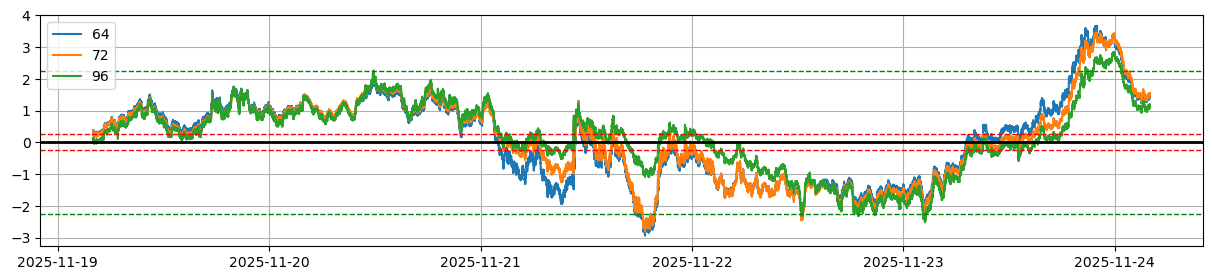

============= IOTA - SAND =============
ACTIVE!
wind: 64; profit:   6.1; ratio:  1.21; drawdown: 0.0; n_trades: 3
wind: 72; profit:   4.2; ratio:  0.82; drawdown: 0.0; n_trades: 2
wind: 96; profit:   3.9; ratio:  0.78; drawdown: 0.0; n_trades: 2


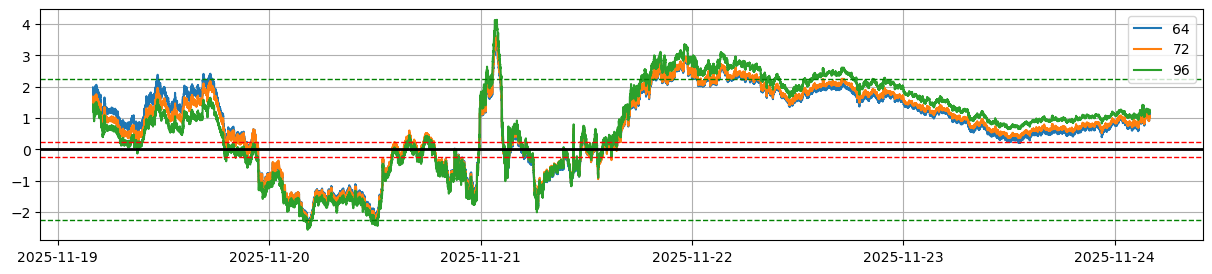

============= CELO - ONDO =============
wind: 64; profit:   6.5; ratio:  1.26; drawdown: 0.0; n_trades: 3
wind: 72; profit:   7.1; ratio:  1.37; drawdown: 0.0; n_trades: 3
wind: 96; profit:   4.7; ratio:  0.91; drawdown: 0.0; n_trades: 2


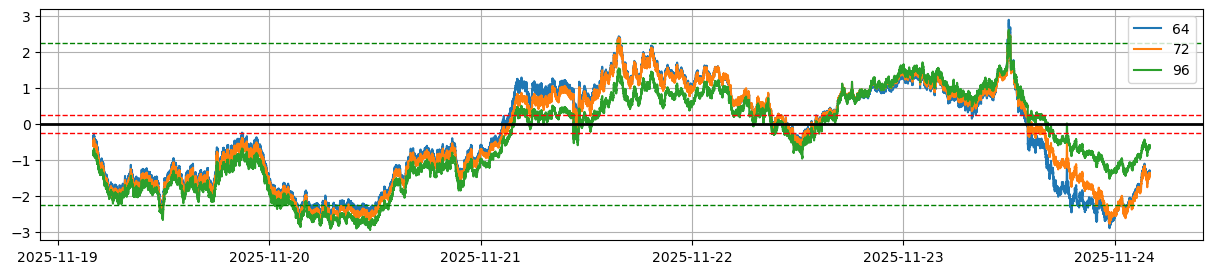

============= ARKM - WIF =============
ACTIVE!
wind: 64; profit:   5.1; ratio:  0.86; drawdown: -1.33; n_trades: 3
wind: 72; profit:   5.5; ratio:  0.93; drawdown: -1.32; n_trades: 3
wind: 96; profit:   8.1; ratio:  1.58; drawdown: 0.0; n_trades: 3


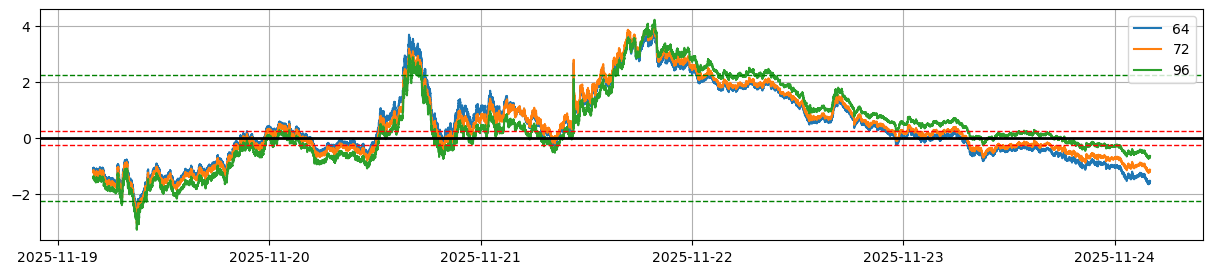

============= FLOW - JUP =============
wind: 64; profit:   1.6; ratio:  0.32; drawdown: 0.0; n_trades: 1
wind: 72; profit:   2.1; ratio:  0.42; drawdown: 0.0; n_trades: 1
wind: 96; profit:   0.4; ratio:  0.08; drawdown: 0.0; n_trades: 1


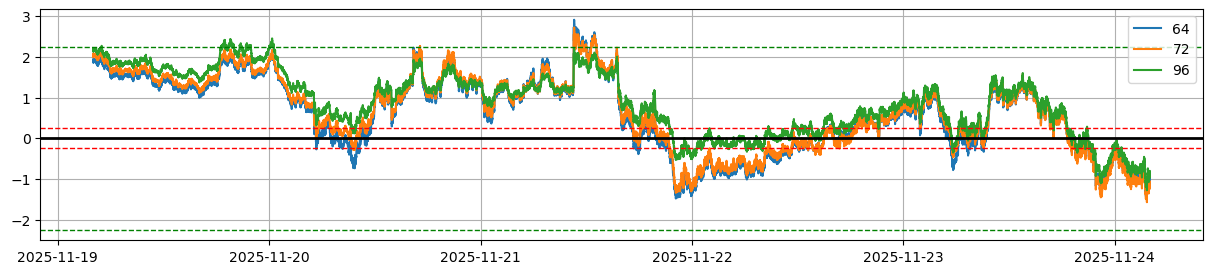

============= ALGO - HBAR =============
wind: 64; profit:   1.4; ratio:  0.28; drawdown: 0.0; n_trades: 1
wind: 72; profit:   3.3; ratio:  0.66; drawdown: 0.0; n_trades: 2
wind: 96; profit:   1.6; ratio:  0.33; drawdown: 0.0; n_trades: 1


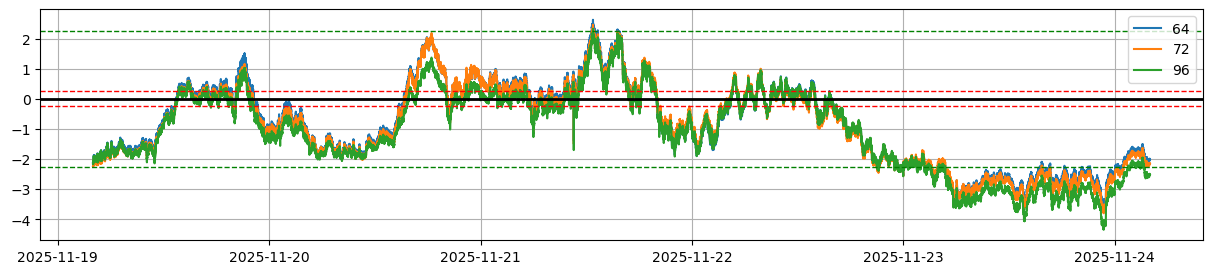

============= MANTA - SUSHI =============
wind: 64; profit:  -5.3; ratio: -0.69; drawdown: -5.32; n_trades: 1
wind: 72; profit:  -3.9; ratio: -0.56; drawdown: -3.86; n_trades: 1
wind: 96; profit:  -0.6; ratio: -0.12; drawdown: -0.63; n_trades: 1


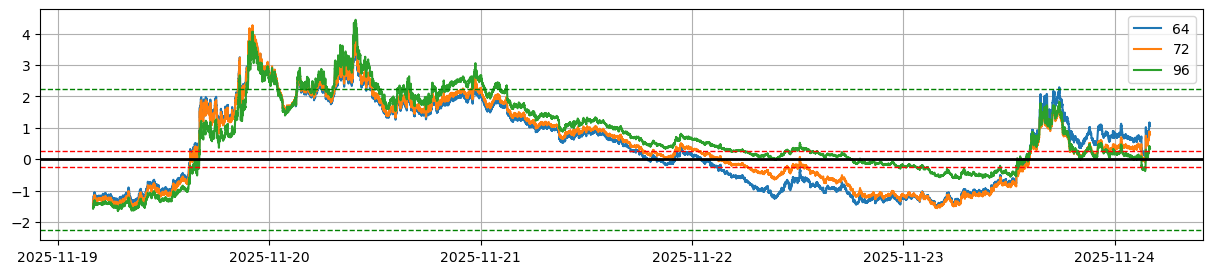

============= STX - WIF =============
wind: 64; profit:  -2.5; ratio: -0.40; drawdown: -2.47; n_trades: 1
wind: 72; profit:  -1.2; ratio: -0.21; drawdown: -1.16; n_trades: 1
wind: 96; profit:   8.7; ratio:  1.73; drawdown: 0.0; n_trades: 3


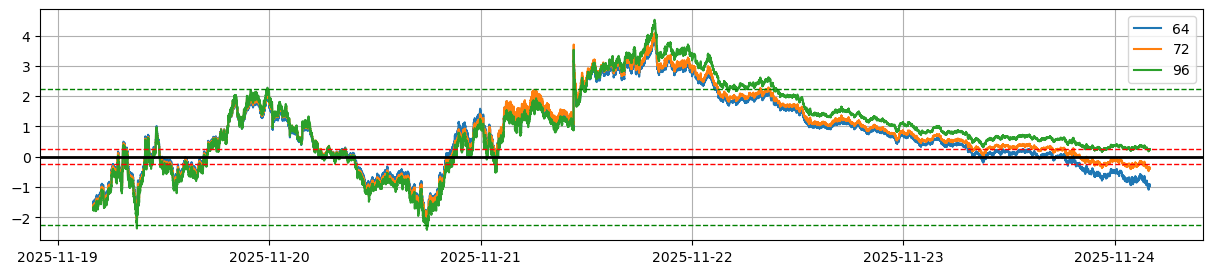

============= APT - INJ =============
wind: 64; profit:   4.4; ratio:  0.88; drawdown: 0.0; n_trades: 2
wind: 72; profit:   4.3; ratio:  0.85; drawdown: 0.0; n_trades: 2
wind: 96; profit:   3.7; ratio:  0.72; drawdown: 0.0; n_trades: 2


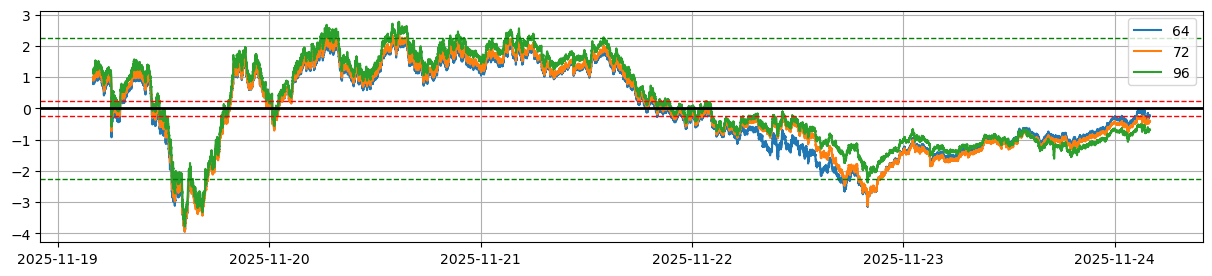

============= ARKM - STX =============
ACTIVE!
wind: 64; profit:   3.7; ratio:  0.72; drawdown: 0.0; n_trades: 2
wind: 72; profit:   3.5; ratio:  0.69; drawdown: 0.0; n_trades: 2
wind: 96; profit:   4.4; ratio:  0.87; drawdown: 0.0; n_trades: 2


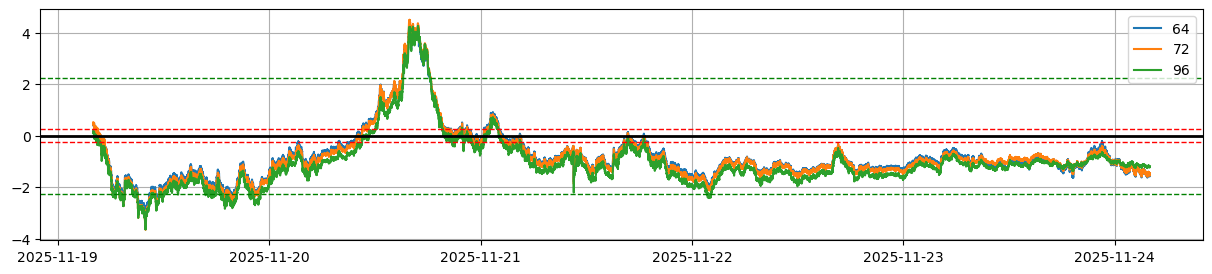

============= JUP - STX =============
wind: 64; profit:   2.5; ratio:  0.49; drawdown: 0.0; n_trades: 2
wind: 72; profit:   3.4; ratio:  0.67; drawdown: 0.0; n_trades: 2
wind: 96; profit:   1.6; ratio:  0.32; drawdown: 0.0; n_trades: 1


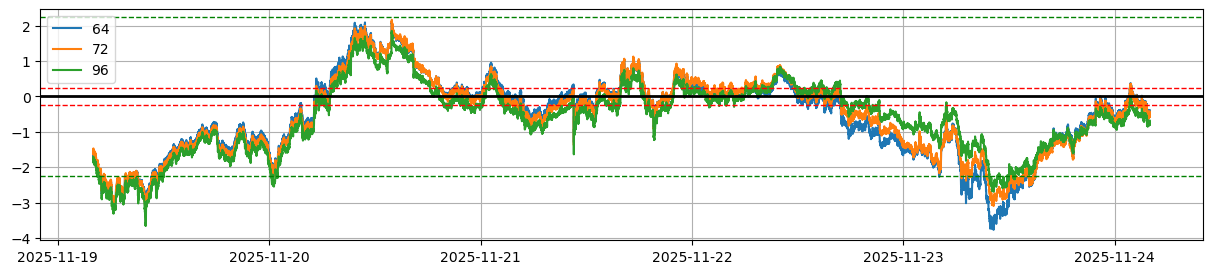

In [19]:
tf = '1h'
winds = np.array([64, 72, 96])
in_ = 2.25
out_ = 0.25


for token_1, token_2 in token_pairs:
    print(f'============= {token_1} - {token_2} =============')
    dp_1 = float(coin_information['bybit_linear'][token_1 + '_USDT']['qty_step'])
    ps_1 = int(coin_information['bybit_linear'][token_1 + '_USDT']['price_scale'])
    dp_2 = float(coin_information['bybit_linear'][token_2 + '_USDT']['qty_step'])
    ps_2 = int(coin_information['bybit_linear'][token_2 + '_USDT']['price_scale'])

    if (token_1, token_2) in current_pairs:
        print('ACTIVE!')

    filepath = f'./data/pair_backtest/{token_1}_{token_2}_1h_{method}.parquet'
    try:
        df = pl.read_parquet(filepath, low_memory=True, rechunk=True, use_pyarrow=True)
    except FileNotFoundError:
        print(f'No Data for {token_1} - {token_2}')
        print()
        continue
        
    end_date = df['time'][-1]
    metrics = dict()

    plt.figure(figsize=(15, 3))
    for wind in winds:
        cols = ['time', 'ts', token_1, f'{token_1}_size', f'{token_1}_bid_price', f'{token_1}_ask_price',
                f'{token_1}_bid_size', f'{token_1}_ask_size', token_2, f'{token_2}_size',
                f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
                f'z_score_{wind}_{tf}']
    
        tdf = df.select(cols).rename({f'z_score_{wind}_{tf}': 'z_score'}).drop_nulls()
        trades_df = backtest(tdf, token_1, token_2, dp_1, dp_2, ps_1, ps_2,
            thresh_low_in=-in_, thresh_low_out=-out_, thresh_high_in=in_, thresh_high_out=out_,
            long_possible=True, short_possible=True,
            balance=100, order_size=50, fee_rate=0.00055, stop_loss_std=8.0, sl_method='leave',
            sl_seconds=60, leverage=leverage, dist_in=0, dist_out=0, verbose=0)
        metrics = analyze_strategy(trades_df, start_date=valid_time, end_date=end_date, initial_balance=100.0)

        if metrics:
            profit = metrics['profit']
            pr_ratio = metrics['profit_ratio']
            max_drawdown = metrics['max_drawdown']
            n_trades = metrics['n_trades']
            print(f'wind: {wind}; profit: {profit:5.1f}; ratio: {pr_ratio:5.2f}; drawdown: {max_drawdown}; n_trades: {n_trades}')

        plt.plot(tdf['time'], tdf['z_score'], label=f'{wind}')
    plt.axhline(y=0, color='black', linestyle='-', linewidth=2)
    plt.axhline(y=-2.25, color='green', linestyle='--', linewidth=1)
    plt.axhline(y=2.25, color='green', linestyle='--', linewidth=1)
    plt.axhline(y=-0.25, color='red', linestyle='--', linewidth=1)
    plt.axhline(y=0.25, color='red', linestyle='--', linewidth=1)
    plt.grid()
    plt.legend()
    plt.show()
    

In [ ]:
# Оставляем только лучшие параметры
leverage = 2
tf = '1h'
wind = 96
in_ = 2.25
out_ = 0.25
dist_in = 0
dist_out = 0
method = 'dist'

metrics_arr = []

for token_1, token_2 in tqdm(token_pairs):
    dp_1 = float(coin_information['bybit_linear'][token_1 + '_USDT']['qty_step'])
    ps_1 = int(coin_information['bybit_linear'][token_1 + '_USDT']['price_scale'])
    dp_2 = float(coin_information['bybit_linear'][token_2 + '_USDT']['qty_step'])
    ps_2 = int(coin_information['bybit_linear'][token_2 + '_USDT']['price_scale'])

    filepath = f'./data/pair_backtest/{token_1}_{token_2}_1h_{method}.parquet'
    try:
        df = pl.read_parquet(filepath, low_memory=True, rechunk=True, use_pyarrow=True)
    except FileNotFoundError:
        continue

    end_date = df['time'][-1]
    metrics = dict()

    cols = ['time', 'ts', token_1, f'{token_1}_size', f'{token_1}_bid_price', f'{token_1}_ask_price',
            f'{token_1}_bid_size', f'{token_1}_ask_size', token_2, f'{token_2}_size',
            f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
            f'z_score_{wind}_{tf}']

    tdf = df.select(cols).rename({f'z_score_{wind}_{tf}': 'z_score'}).drop_nulls()

    trades_df = backtest(tdf, token_1, token_2, dp_1, dp_2, ps_1, ps_2,
            thresh_low_in=-in_, thresh_low_out=-out_, thresh_high_in=in_, thresh_high_out=out_,
            long_possible=True, short_possible=True,
            balance=100, order_size=50, fee_rate=0.00055, stop_loss_std=8.0, sl_method='leave',
            sl_seconds = 60, leverage=leverage, dist_in=0, dist_out=0,
            verbose=0)

    if trades_df.height > 1:
        metrics = analyze_strategy(trades_df, start_date=valid_time, end_date=end_date, initial_balance=100.0)

    if metrics:
        metrics_arr.append({
            'token_1': token_1, 'token_2': token_2, 'tf': tf, 'wind': wind,
            'thresh_in': in_, 'thresh_out': out_, 'dist_in': dist_in, 'dist_out': dist_out,
            'n_trades': metrics['n_trades'], 'duration_avg': metrics['duration_avg'],
            'stop_losses': metrics['stop_losses'], 'liquidations': metrics['liquidations'],
            'profit': metrics['profit'], 'profit_ratio': metrics['profit_ratio'],
            'max_profit': metrics['max_profit'], 'max_drawdown': metrics['max_drawdown'],
            'max_loss': metrics['max_loss'], 'avg_profit': metrics['avg_profit'],
            'profit_std': metrics['profit_std']})

best_output = pl.DataFrame(metrics_arr).sort(by='profit', descending=True)

In [ ]:
best_output['profit'].sum()

In [ ]:
best_output.height

In [ ]:
best_res = best_output.group_by('token_1', 'token_2').agg(
            pl.col('profit').sum().round(2).alias('profit'),
            pl.col('max_loss').min().round(2).alias('max_loss'),
            pl.col('max_drawdown').mean().round(2).alias('avg_drawdown'),
            pl.col('max_drawdown').min().round(2).alias('max_drawdown'),
            pl.col('duration_avg').mean().alias('duration_avg'),
            pl.col('profit_ratio').mean().round(2).alias('profit_ratio'),
            pl.col('n_trades').mean().cast(pl.Int64).alias('n_trades'),
        ).filter(
            pl.col('profit') > 2
        ).sort('profit_ratio', descending=True)
best_res[0:10]

In [ ]:
best_res.select(
    'token_1', 'token_2', 'profit', 'profit_ratio', 'max_loss', 'max_drawdown', 'duration_avg', 'n_trades'
).write_parquet(f'./data/pair_selection/best_params_{method}_result.parquet')

#### Отбор монет

In [ ]:
method = 'dist'
pairs = pl.read_parquet('./data/pair_selection/curr_pairs.parquet')

common_params = pl.read_parquet(f'./data/pair_selection/common_params_{method}_result.parquet')
common_params = common_params.rename({'token_1': 'coin1', 'token_2': 'coin2', 'avg_profit': 'avg_pr_all', 'profit_std': 'pr_std_all',
                                     'max_loss': 'loss_all', 'avg_drawdown': 'avg_drdn_all', 'max_drawdown': 'max_drdn_all',
                                     'avg_duration': 'dur_all', 'avg_pr_ratio': 'pr_rat_all', 'avg_trades': 'trades_all'})

best_params = pl.read_parquet(f'./data/pair_selection/best_params_{method}_result.parquet')
best_params = best_params.rename({'token_1': 'coin1', 'token_2': 'coin2', 'profit': 'pr_best', 'profit_ratio': 'pr_rat_best',
                                     'max_loss': 'loss_best', 'max_drawdown': 'max_drdn_best',
                                     'duration_avg': 'dur_best', 'n_trades': 'trades_best'})

pairs = pairs.with_columns(
    pl.col('spr_dist').round(2),
    pl.col('spr_std').round(2),
    pl.col('corr').round(2),
    pl.col('pv_1').round(2),
    pl.col('pv_2').round(2),
)

pairs = pairs.join(best_params, on=['coin1', 'coin2'])

cols_to_rename = {'pr_best': 'profit', 'pr_rat_best': 'profit_ratio', 'loss_best': 'max_loss', 'max_drdn_best': 'max_drn',
                 'dur_best': 'avg_duration', 'trades_best': 'trades'}
pairs = pairs.rename(cols_to_rename).sort('profit_ratio', descending=True)

pairs = pairs.filter(
    (abs(pl.col('beta_1') - pl.col('beta_2')) < 1.4) & (pl.col('profit') > 2) & (pl.col('spr_dist') < 2.8) & (pl.col('corr') > 0.75)
    & (pl.col('pv_1') < 0.05) & (pl.col('pv_2') < 0.05)
).sort(by='profit', descending=True)

In [ ]:
pairs#[0:30]

In [ ]:
# Жадный метод
used_tokens = []
trade_pairs_list = []
total_profit = 0

for row in pairs.iter_rows(named=True):
    t1 = row['coin1']
    t2 = row['coin2']
    profit = row['profit']
    
    if t1 in used_tokens or t2 in used_tokens:
        continue

    trade_pairs_list.append((t1, t2))
    used_tokens.append(t1)
    used_tokens.append(t2)
    total_profit += profit
    print(t1, t2, profit)
print('Общий профит:', round(total_profit, 1))

In [ ]:
import networkx as nx

In [ ]:
df = pairs.filter(
    abs(pl.col('beta_1') - pl.col('beta_2')) < 1.8
).with_columns([
        pl.when(pl.col("coin1") < pl.col("coin2")).then(pl.col("coin1")).otherwise(pl.col("coin2")).alias("a"),
        pl.when(pl.col("coin1") < pl.col("coin2")).then(pl.col("coin2")).otherwise(pl.col("coin1")).alias("b"),
])

In [ ]:
edges = df.group_by(["a","b"]).agg(
    pl.max("profit").alias("weight")
)

In [ ]:
G = nx.Graph()
for row in edges.to_dicts():
    # row: {"a": "BLUR", "b":"MANTA", "weight": 28.33}
    G.add_edge(row["a"], row["b"], weight=float(row["weight"]))

In [ ]:
matching = nx.max_weight_matching(G, maxcardinality=False, weight="weight")

In [ ]:
matched_rows = []
total = 0.0
for u, v in matching:
    w = G[u][v]["weight"]
    matched_rows.append({"coin1": u, "coin2": v, "profit": w})
    total += w

In [ ]:
matched_df = pl.DataFrame(matched_rows)

In [ ]:
print("Matched pairs:")
print(matched_df[:])
print(f"Total profit: {total:.2f}")

In [ ]:
pairs.filter(pl.col('coin1') == 'DYDX')

In [ ]:
token_pairs = []
with open('./bot/config/token_pairs.txt', 'r') as file:
    for line in file:
        a, b = line.strip().split()
        token_pairs.append((a, b))

In [ ]:
tf = '1h'
wind = 72
winds = np.array([wind])

valid_length = 5
train_length = 3
min_order = 42

end_time = datetime.now().replace(tzinfo=ZoneInfo("Europe/Moscow"))
valid_time = (end_time - timedelta(days=valid_length)).replace(hour=0, minute=0, second=0, microsecond=0)
start_time = valid_time - timedelta(days=train_length)
start_ts = int(datetime.timestamp(valid_time))


# for row in pairs.iter_rows(named=True):
#     token_1 = row['coin1']
#     token_2 = row['coin2']
for token_1, token_2 in token_pairs:
    df_1 = db_manager.get_tick_ob(token=token_1 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)
    df_2 = db_manager.get_tick_ob(token=token_2 + '_USDT',
                                         start_time=start_time,
                                         end_time=end_time)    
    df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time)
    tick_df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time)
    agg_df = make_trunc_df(df, timeframe=tf, token_1=token_1, token_2=token_2, method='triple')
    spread_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, winds, min_order, start_ts, 
                                 median_length=6, spr_method='dist')
    plt.figure(figsize=(15, 3))
    plt.title(f'{token_1} - {token_2} (tf: {tf}; wind: {wind})')
    plt.plot(spread_df['time'], spread_df[f'z_score_{wind}_{tf}'], c='green')
    plt.grid()
    plt.show()


In [ ]:
# Плохие пары: SUSHI - SEI; CHZ - VET; MANTA - CELO; 

# Хорошие пары: ARKM - OP; ARKM - CELO; IOTA - MANA; GMT - BLUR; XRP - LDO; ARKM - STX; ARKM - ONDO; IOTA - KAS; 

# Непонятные: ARKM - MANTA; 

In [ ]:
trading_history = db_manager.get_table('trading_history', df_type='polars')

res_df = trading_history.group_by('token_1', 'token_2').agg(
        pl.col('profit').sum().round(2),
        pl.col('profit').min().round(2).alias('min_profit'),
        pl.col('profit').max().round(2).alias('max_profit'),
        (pl.col('profit').sum() / pl.col('profit').len()).round(2).alias('avg_profit'),
        pl.col('profit').len().alias('n_trades'),
    
    ).sort(by='profit', descending=True)

res_df = res_df.join(pairs, left_on=('token_1', 'token_2'), right_on=('coin1', 'coin2')).sort('profit', descending=True)
# res_df = res_df.rename({'dist': 'spr_dist', 'std': 'spr_std'})
res_df.shape

In [ ]:
res_df

In [ ]:
cols = ['token_1', 'token_2', 'profit', 'min_profit', 'max_profit', 'avg_profit', 'n_trades', 'spr_dist', 'spr_std', 'std_1', 'std_2',
       'dist_1', 'dist_2', 'corr', 'pv_1', 'pv_2', 'avg_pr_all', 'pr_std_all', 'loss_all', 'avg_drdn_all', 'max_drdn_all', 'pr_rat_all',
       'pr_best', 'pr_rat_best', 'loss_best', 'max_drdn_best']

In [ ]:
res_df.select(cols).head(10)

In [ ]:
res_df.select(cols).tail(5)

In [ ]:
pairs.filter((pl.col('coin1') == 'CELO') & (pl.col('coin2') == 'IMX'))

#### ML

In [ ]:
df = pairs.select('coin1', 'coin2', 'dist', 'std', 'corr', 'pv_1', 'pv_2', 'pr_ind', 'pr_rat_ind', 'avg_pr_all', 'pr_rat_all',
            'pr_best', 'pr_rat_best', 'loss_best', 'max_drdn_best', 'dur_best', 'trades_best', 
            # 'pr_test', 'pr_rat_test', 'loss_test', 'max_drdn_test', 'dur_test', 'trades_test'
                 )

In [ ]:
df.shape

In [ ]:
df.sample(3)

In [ ]:
X, y = df.drop('pr_rat_test'), df['pr_rat_test']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
X_test.with_columns(
    pl.Series(y_test).alias('pr_rat_real')
).filter((pl.col('pr_rat_best') > 0.5) & (pl.col('pr_rat_all') > 0.5))#['pr_rat_real'].sum()

In [ ]:
4.753

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train);
lr_preds = lr.predict(X_test)
root_mean_squared_error(y_test.to_numpy(), lr_preds)

In [ ]:
# 0.8532 -> 0.8286 (добавил фичу std)

In [ ]:
for name, coef in zip(lr.feature_names_in_, lr.coef_):
    print(f'{name:>15}: {coef:>7.4f}')

In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [ ]:
params = {'eps': [0.0001, 0.001, 0.01]}

lasso = LassoCV(random_state=42)
gcv = GridSearchCV(lasso, params, cv=5, n_jobs=12, verbose=0)
gcv.fit(X_train, y_train);

In [ ]:
gcv.best_params_

In [ ]:
lasso = LassoCV(random_state=42, eps=0.0001)
lasso.fit(X_train, y_train);
lasso_preds = lasso.predict(X_test)
root_mean_squared_error(y_test.to_numpy(), lasso_preds)

In [ ]:
# 0.8211

In [ ]:
for name, coef in zip(lasso.feature_names_in_, lasso.coef_):
    print(f'{name:>15}: {coef:>7.4f}')

In [ ]:
ridge = RidgeCV()
ridge.fit(X_train, y_train);
ridge_preds = ridge.predict(X_test)
root_mean_squared_error(y_test.to_numpy(), ridge_preds)

In [ ]:
# 0.8118 -> 0.8117 (+ std)

In [ ]:
for name, coef in zip(ridge.feature_names_in_, ridge.coef_):
    print(f'{name:>15}: {coef:>7.4f}')

In [ ]:
params = {'max_features': [4, 6, 8, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5, 6, 8, 10, 12, 15],
          'n_estimators': [40, 60, 80, 100, 125, 150]}

rfr = RandomForestRegressor(random_state=42)
gcv = GridSearchCV(rfr, params, cv=5, n_jobs=12, verbose=0)
gcv.fit(X_train, y_train);

In [ ]:
gcv.best_params_

In [ ]:
rf = RandomForestRegressor(random_state=42, n_estimators=80, max_depth=12, max_features=6, min_samples_leaf=5)
rf.fit(X_train, y_train);
rf_preds = rf.predict(X_test)
root_mean_squared_error(y_test.to_numpy(), rf_preds)

In [ ]:
# 0.7634 -> 0.7750 (+std)

In [ ]:
for name, coef in zip(rf.feature_names_in_, rf.feature_importances_):
    print(f'{name:>15}: {coef:>7.4f}')

In [ ]:
X_test.with_columns(
    pl.Series(rf_preds).alias('pr_rat_pred'),
    pl.Series(y_test).alias('pr_rat_real')
).filter(pl.col('pr_rat_pred') > 0.4)#['pr_rat_real'].sum()

In [ ]:
# 4.325

In [ ]:
params = {'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2], 'max_features': [4, 6, 8, 10, 13], 
          'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5, 6, 8, 10, 12, 15],
          'n_estimators': [40, 60, 80, 100, 125, 150]}

gbr = GradientBoostingRegressor(random_state=42)
gcv = GridSearchCV(gbr, params, cv=5, n_jobs=12, verbose=0)
gcv.fit(X_train, y_train);

In [ ]:
gcv.best_params_

In [ ]:
gbr = GradientBoostingRegressor(random_state=42, learning_rate=0.01, n_estimators=80, max_depth=5, 
                                max_features=4, min_samples_leaf=7)
gbr.fit(X_train, y_train);
gbr_preds = gbr.predict(X_test)
root_mean_squared_error(y_test.to_numpy(), gbr_preds)

In [ ]:
# 0.8004 -> 0.8014

In [ ]:
import catboost as cb

In [ ]:
params = {'learning_rate': [0.01, 0.03, 0.1, 0.3], 'iterations': [250, 500, 1000], 
          'depth': [6, 8, 10],
          'l2_leaf_reg': [1, 3, 5, 7]}
cbr = cb.CatBoostRegressor(random_state=42, verbose=False)
gcv = GridSearchCV(cbr, params, cv=5, verbose=0)
gcv.fit(X_train.to_numpy(), y_train.to_numpy());

In [ ]:
gcv.best_params_

In [ ]:
train_pool = cb.Pool(X_train.to_numpy(), y_train.to_numpy())

In [ ]:
param_grid = {
    'iterations': tune.randint(100, 1500),
    'learning_rate': tune.loguniform(1e-3, 0.5),
    'depth': tune.randint(4, 12),
    'l2_leaf_reg': tune.loguniform(1, 10),
}

In [ ]:
cb.__version__

In [ ]:
from catboost.utils import grid_search

In [ ]:
cbr = cb.CatBoostRegressor(random_state=42, verbose=False, learning_rate=0.01, iterations=800, depth=8,
                          loss_function='Expectile:alpha=0.7'
                          )
cbr.fit(X_train.to_numpy(), y_train.to_numpy());
cbr_preds = cbr.predict(X_test.to_numpy())
root_mean_squared_error(y_test.to_numpy(), cbr_preds)

In [ ]:
cbr.save_model('./data/catboost_model.json', format='json')

In [ ]:
# 0.7172

In [ ]:
for name, coef in zip(X_test.columns, cbr.feature_importances_):
    print(f'{name:>15}: {coef:>7.4f}')

In [ ]:
X_test.with_columns(
    pl.Series(cbr_preds).alias('pr_rat_pred'),
    pl.Series(y_test).alias('pr_rat_real')
).filter(pl.col('pr_rat_pred') > 0.4)['pr_rat_real'].sum()

In [ ]:
# RMSE: 5.73
# Quantile, alpha=0.7 : 9.45,  RMSE: 0.7362
# Quantile, alpha=0.65: 9.07,  RMSE: 0.7172
# Quantile, alpha=0.6 : 10.04, RMSE: 0.7522
# Quantile, alpha=0.55: 6.65,  RMSE: 0.7392
# Quantile, alpha=0.5 : 5.06, RMSE: 0.7650
# Quantile, alpha=0.4 : 3.56, RMSE: 0.7893
# Quantile, alpha=0.3 : 3.56,  RMSE: 0.8197

# Expectile, alpha=0.3 : 6.25, RMSE: 0.7571
# Expectile, alpha=0.4 : 8.97, RMSE: 0.7603
# Expectile, alpha=0.5 : 9.60, RMSE: 0.7435
# Expectile, alpha=0.6 : 8.97, RMSE: 0.7535
# Expectile, alpha=0.65: 9.60, RMSE: 0.7323
# Expectile, alpha=0.7 : 9.60, RMSE: 0.7214
# Expectile, alpha=0.75: 10.04, RMSE: 0.7260
# Expectile, alpha=0.8 : 9.87, RMSE: 0.7344

In [ ]:
X_test.with_columns(
    pl.Series(cbr_preds).alias('pr_rat_pred'),
    pl.Series(y_test).alias('pr_rat_real')
).filter(pl.col('pr_rat_pred') > 0.4)

In [ ]:
model = cb.CatBoostRegressor()
model.load_model('./data/catboost_model.json', format='json')

In [ ]:
df.sample(2)

In [ ]:
df = df.drop('coin1', 'coin2', 'dur_best', 
            # 'dur_test', 'trades_test', 'loss_test', 'max_drdn_test', 'pr_test'
            )

X = df.to_numpy()

In [ ]:
preds = model.predict(X)

In [ ]:
df = pairs.select('coin1', 'coin2', 'dist', 'std', 'corr', 'pv_1', 'pv_2', 'pr_ind', 'pr_rat_ind', 'avg_pr_all', 'pr_rat_all',
            'pr_best', 'pr_rat_best', 'loss_best', 'max_drdn_best', 'dur_best',
            # 'pr_test', 'pr_rat_test', 'loss_test', 'max_drdn_test', 'dur_test', 'trades_test'
                 )

trade_pairs_df = df.with_columns(
        pl.Series(preds).alias('pred'),
    ).filter(
        (pl.col('pr_rat_ind') > 0.4) & (pl.col('pr_rat_all') > 0.4) & (pl.col('pr_rat_best') > 0.4) #& (pl.col('pred') > 0.4)
    ).sort(by='pr_rat_all', descending=True)


In [ ]:
trade_pairs_df

In [ ]:
used_tokens = []
trade_pairs_list = []

for row in trade_pairs_df.iter_rows(named=True):
    t1 = row['coin1']
    t2 = row['coin2']
    
    if t1 in used_tokens or t2 in used_tokens:
        continue

    trade_pairs_list.append((t1, t2))
    used_tokens.append(t1)
    used_tokens.append(t2)

In [ ]:
used_tokens

In [ ]:
trade_pairs_list

In [ ]:
from jaref_bot.db.postgres_manager import DBManager
from jaref_bot.config.credentials import host, user, password, db_name

db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

In [ ]:
current_pairs = db_manager.get_table('pairs', df_type='polars')
current_pairs

In [ ]:
for row in current_pairs.iter_rows(named=True):
    t1 = row['token_1'][:-5]
    t2 = row['token_2'][:-5]
    
    if (t1, t2) not in trade_pairs_list:
        trade_pairs_list.append((t1, t2))
        print((t1, t2))

In [ ]:
with open('./jaref_bot/config/token_pairs.txt', 'w') as file:
    for pair in trade_pairs_list:
        file.write(f"{pair[0]} {pair[1]}\n")